# 신용카드 사기거래 탐지
<hr>

### Kaggle의 [Creadit Card Transaction Fraud Dataset](https://www.kaggle.com/datasets/kartik2112/fraud-detection)을 이용한 신용카드 사기거래 데이터 분석 및 분류 예측

### 목차
1. 데이터셋 불러오기
2. 탐색적 데이터 분석 (EDA) 및 전처리
3. 예측 모델을 위한 Feature 선택
4. 데이터 불균형 문제 해결
5. 모델 선정 및 학습
6. 결과

<hr>

# 
# 1. 데이터셋 불러오기

trans_date_trans_time - 거래발생시간
<br>
cc_num - 카드번호
<br>
merchant - 상점
<br>
category - 상점그룹
<br>
amt - 거래금액 
<br>
merch_lat - 상점 위치 위도
<br>
merch_long - 상점 위치 경도
<br>
trans_num - 거래번호
<br>
unix_time - 거래발생시간 (unix time)
<br>

#### 카드 소유주 정보
first - 이름    
last - 성     
gender - 성별   
street - 주소   
city - 도시     
state - 주    
zip - 우편번호      
lat - 위도      
long - 경도     
city_pop - 인구
job - 생년월일     
dob - 직업

In [1]:
import utils
import models
import train
import datasets
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_train, y_train = datasets.load_train_dataset()
X_test, y_test = datasets.load_test_dataset()

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   first                  1296675 non-null  object        
 6   last                   1296675 non-null  object        
 7   gender                 1296675 non-null  object        
 8   street                 1296675 non-null  object        
 9   city                   1296675 non-null  object        
 10  state                  1296675 non-null  object        
 11  zip                    1296675 non-null  int64         
 12  lat                    12966

<hr>

# 
# 2.  탐색적 데이터 분석 (EDA) 및 전처리

1. 거래금액 이상치 제거
2. 고연령층에서 사기거래 비율이 높음
3. 사기거래가 주로 22-4시에 뚜렷이 발생
4. 상점그룹별 사기거래의 상대적 발생 차이가 뚜렷함
5. 사기거래에 비해 일반거래의 클러스터링이 더 뚜렷하게 나타남 (사기거래 발생 위치가 더 퍼져있음)

### 
### 상관관계분석

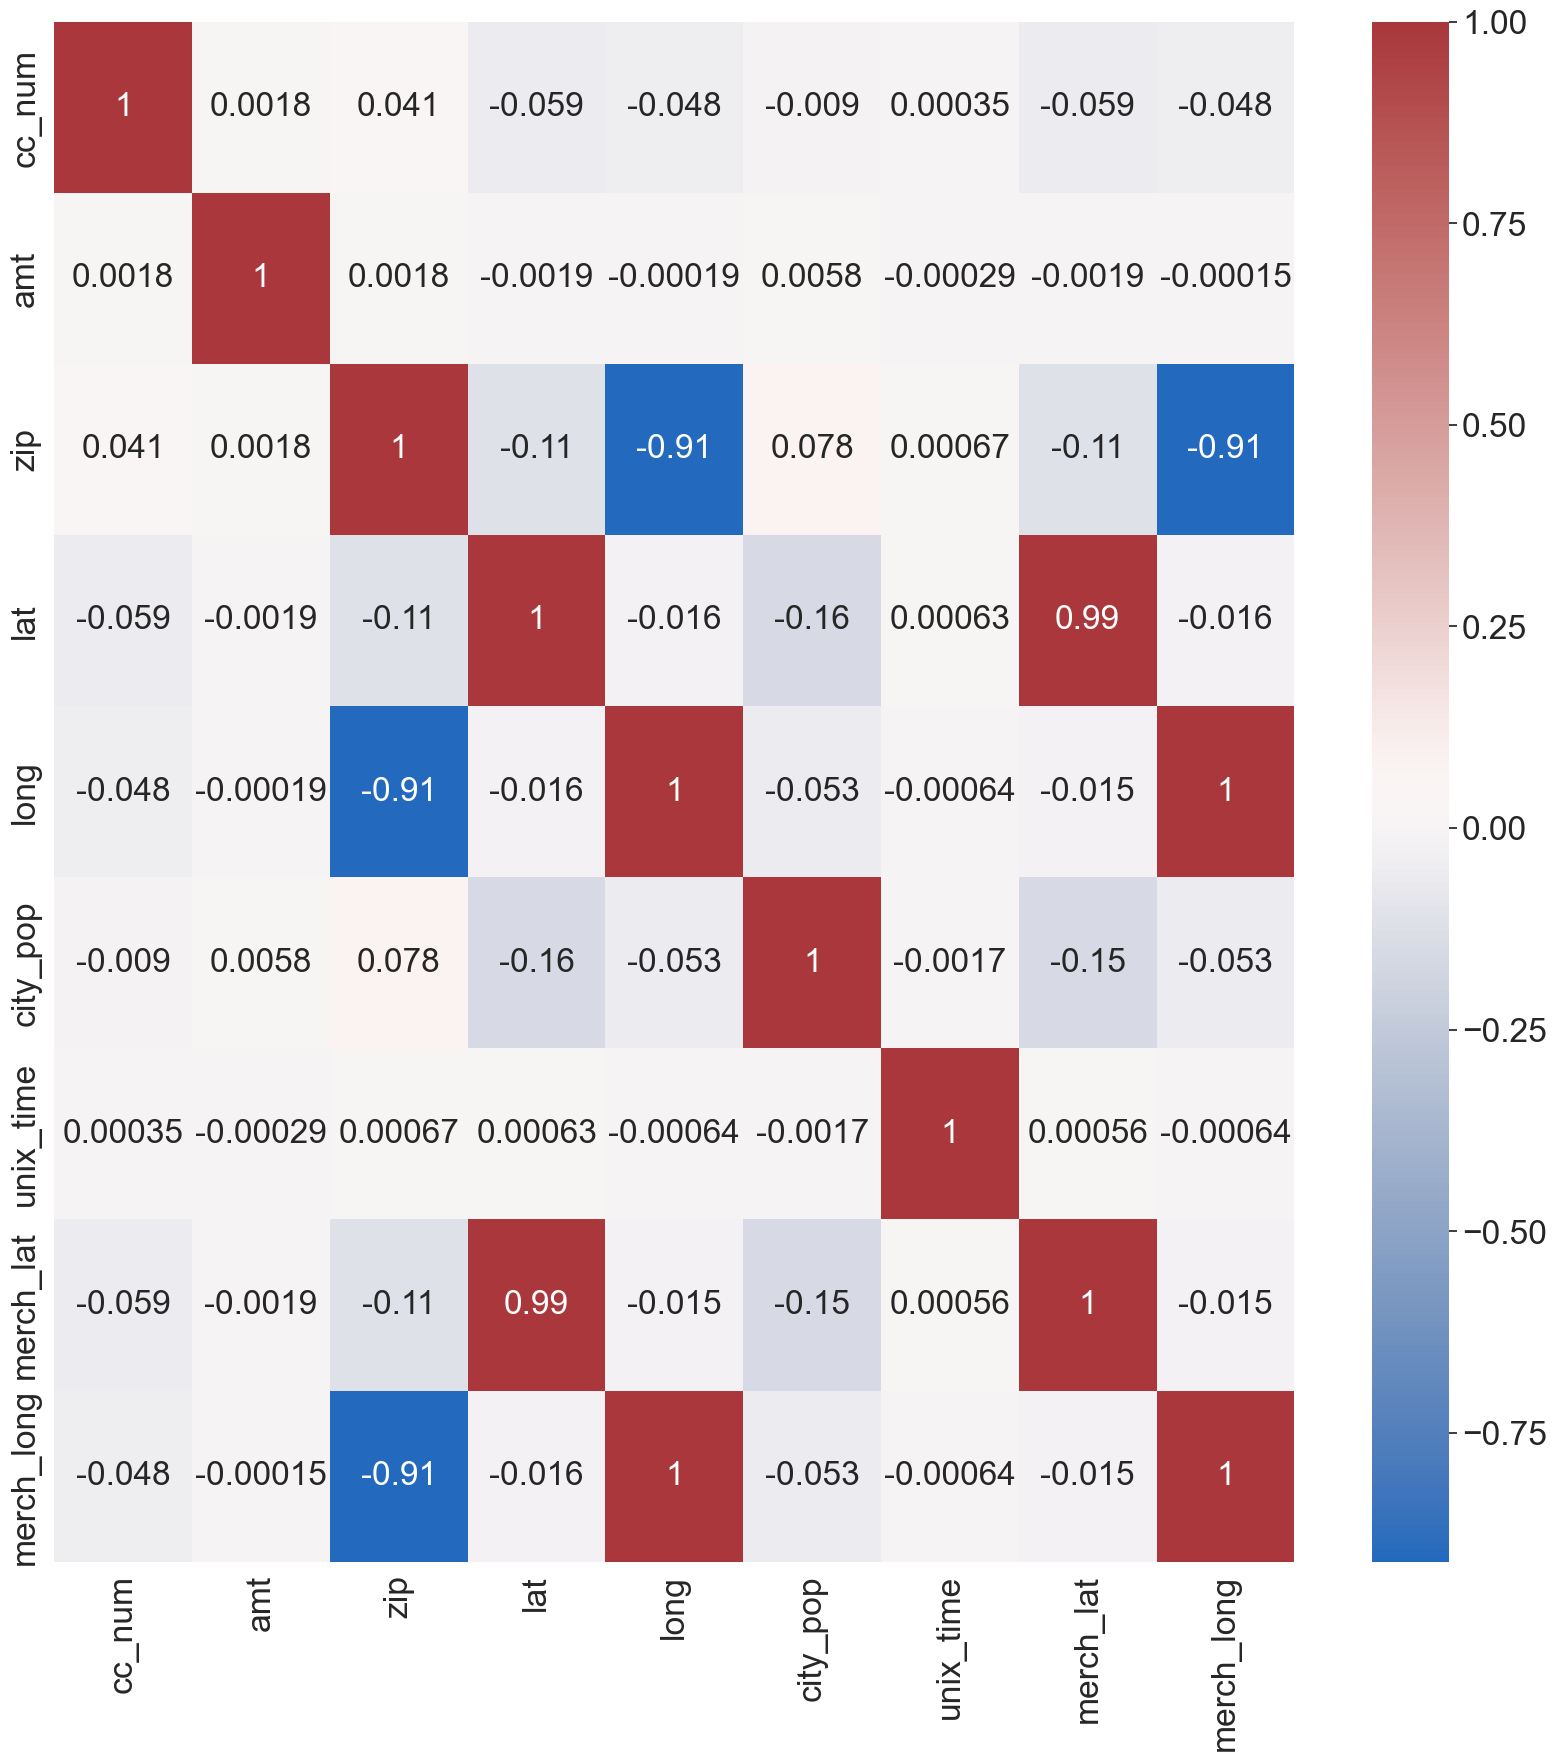

In [4]:
utils.draw_heatmap(X_train)

### 
### 피쳐 추가, 인코딩 및 이름 변경

In [5]:
# 칼럼 이름 변경
X_train.rename(columns={"trans_date_trans_time": "trans_time"}, inplace=True)
X_test.rename(columns={"trans_date_trans_time": "trans_time"}, inplace=True)
X_train.rename(columns={"category": "merch_cat"}, inplace=True)
X_test.rename(columns={"category": "merch_cat"}, inplace=True)
# 레이블 인코딩
utils.convert_category_to_num_label(X_train, 'gender')
utils.convert_category_to_num_label(X_test, 'gender')
# 시간 칼럼 추가
X_train['hour'] = X_train['trans_time'].dt.hour
X_test['hour'] = X_test['trans_time'].dt.hour
# 요일 칼럼 추가
X_train['day'] = X_train['trans_time'].dt.weekday
X_test['day'] = X_test['trans_time'].dt.weekday
# 월별 칼럼 추가
X_train['month'] = X_train['trans_time'].dt.month
X_test['month'] = X_test['trans_time'].dt.month
# 나이 칼럼 추가
X_train['age'] = 2020 - X_train['dob'].dt.year
X_test['age'] = 2020 - X_test['dob'].dt.year

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 25 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   trans_time  1296675 non-null  datetime64[ns]
 1   cc_num      1296675 non-null  int64         
 2   merchant    1296675 non-null  object        
 3   merch_cat   1296675 non-null  object        
 4   amt         1296675 non-null  float64       
 5   first       1296675 non-null  object        
 6   last        1296675 non-null  object        
 7   gender      1296675 non-null  int64         
 8   street      1296675 non-null  object        
 9   city        1296675 non-null  object        
 10  state       1296675 non-null  object        
 11  zip         1296675 non-null  int64         
 12  lat         1296675 non-null  float64       
 13  long        1296675 non-null  float64       
 14  city_pop    1296675 non-null  int64         
 15  job         1296675 non-null  ob

### 
### 일반거래(왼쪽)와 사기거래(오른쪽)의 거래금액 (이상치 포함) 분포

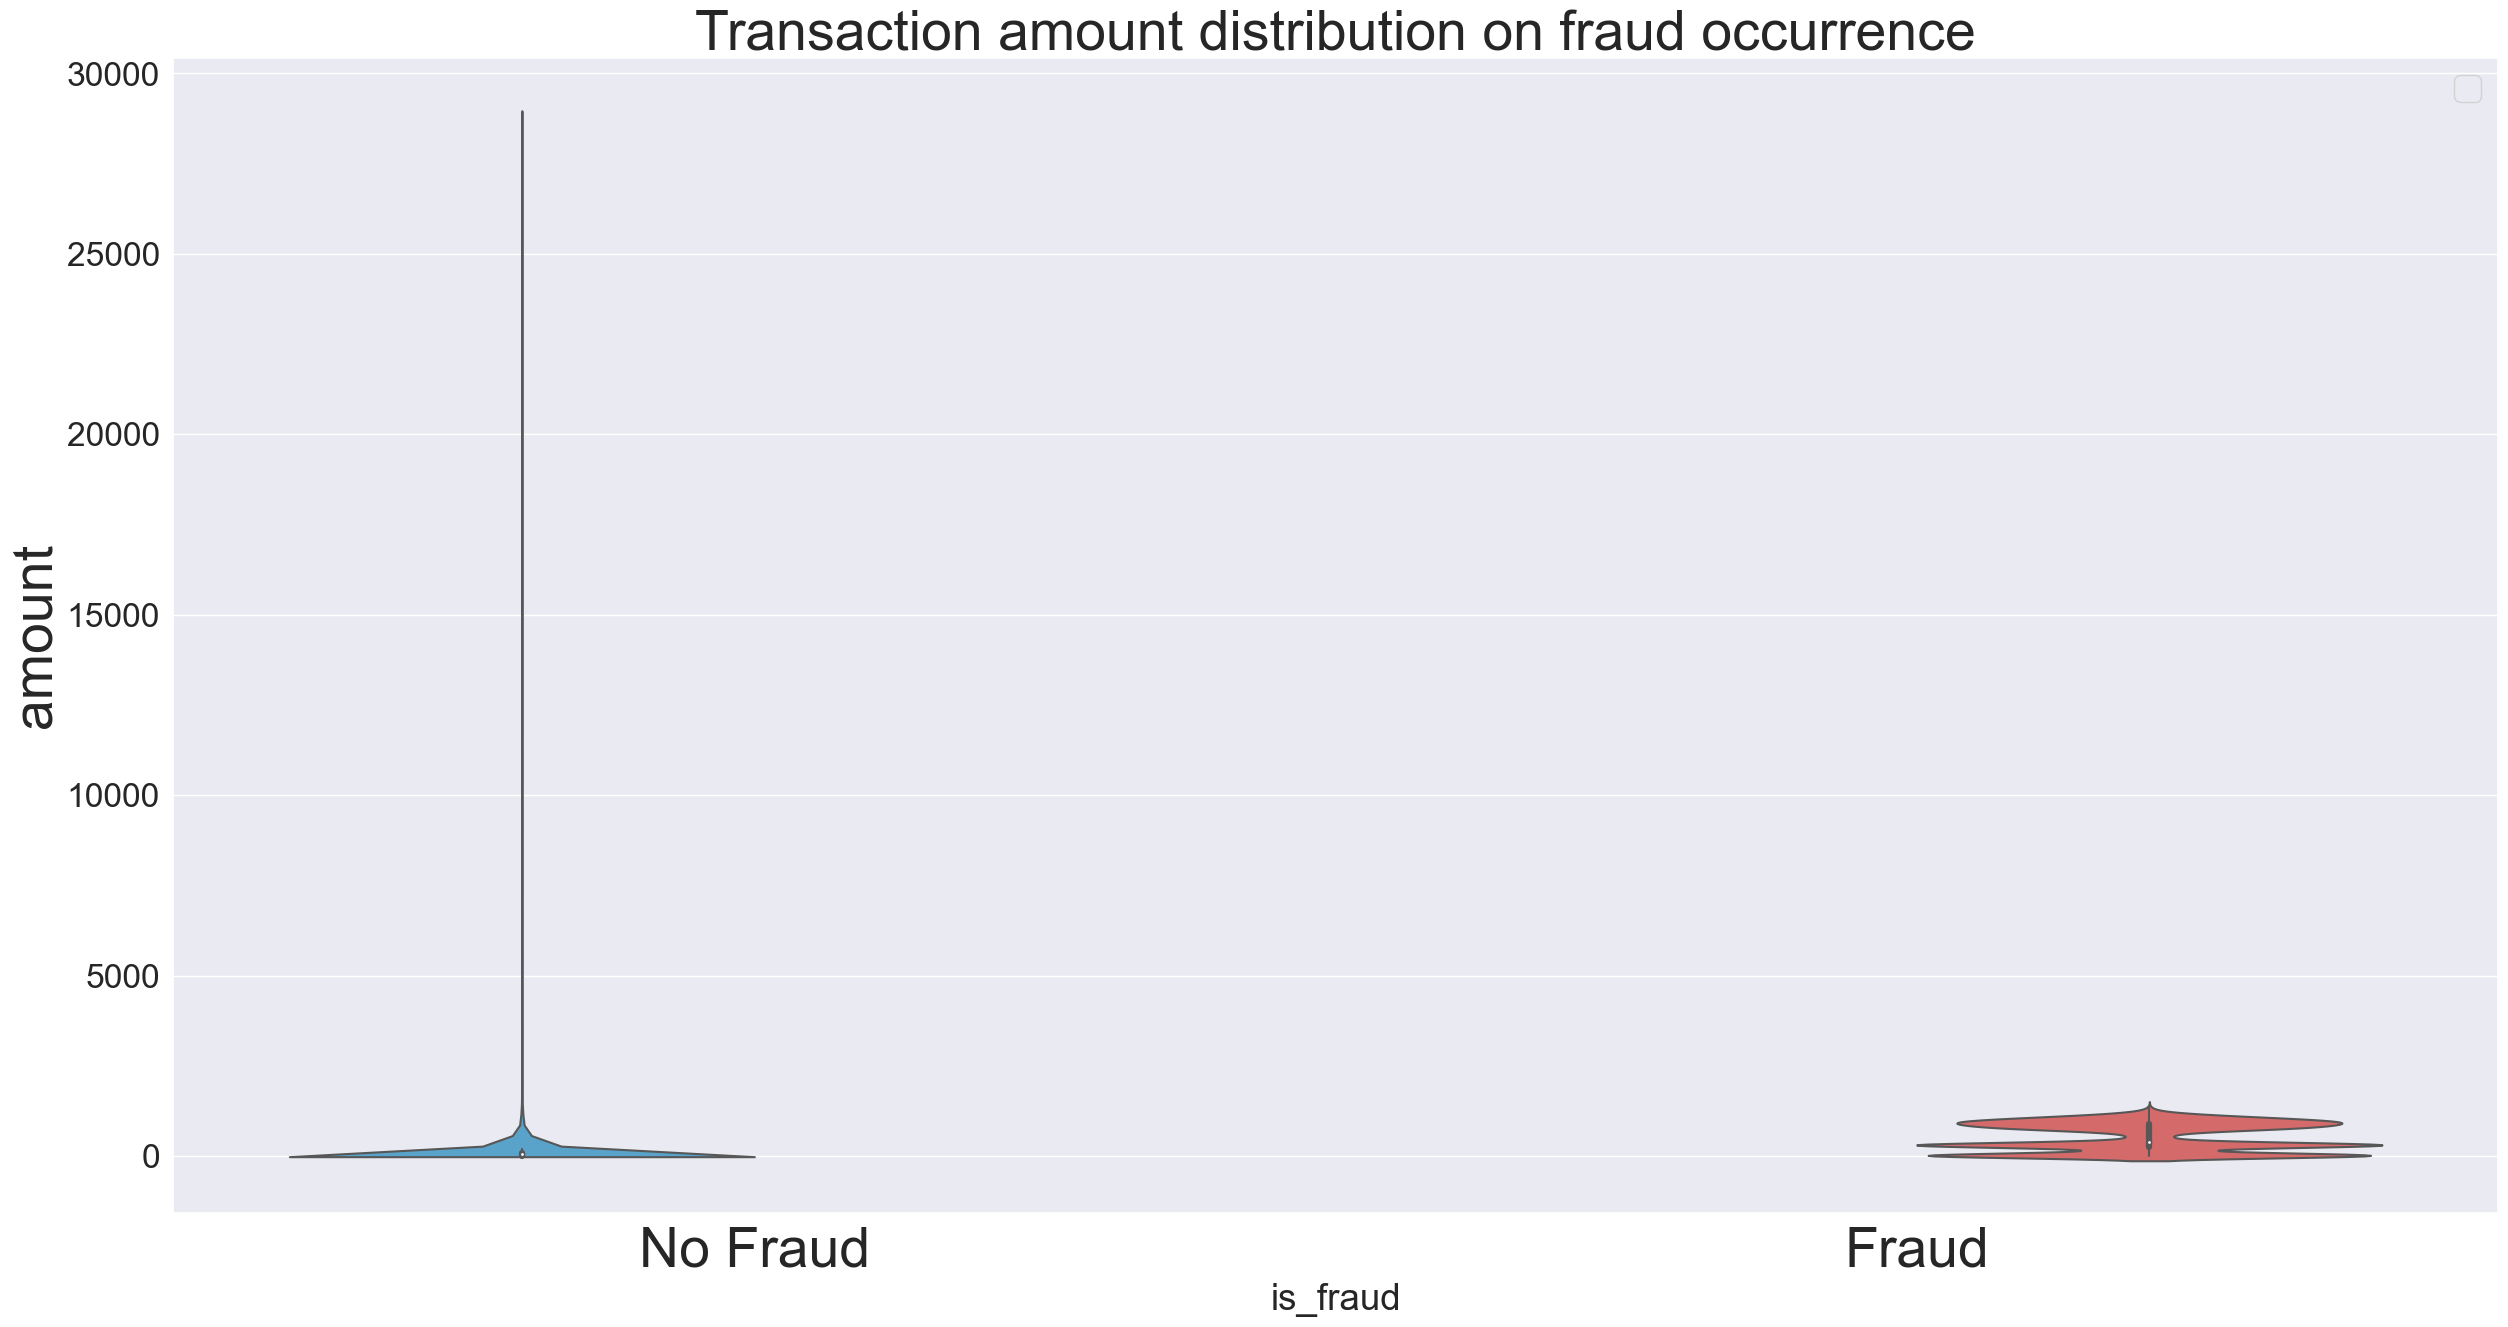

In [7]:
plt.figure(figsize=(30,15))

amt_fraud_df = pd.concat([X_train['amt'], y_train], axis=1)
ax = sns.violinplot(data=amt_fraud_df, x='is_fraud', y='amt', hue='is_fraud', 
                    palette={0: '#46A7DC', 1: "#E75858"})
utils.set_plot_labels(ax, 
                      title=('Transaction amount distribution on fraud occurrence', 40),  
                      ylab=('amount',40))
ax.set_xticklabels(['No Fraud', 'Fraud'], fontsize=40)
ax.legend([])

plt.show()

### 
### 일반거래(왼쪽)와 사기거래(오른쪽)의 거래금액 (이상치 제거) 분포

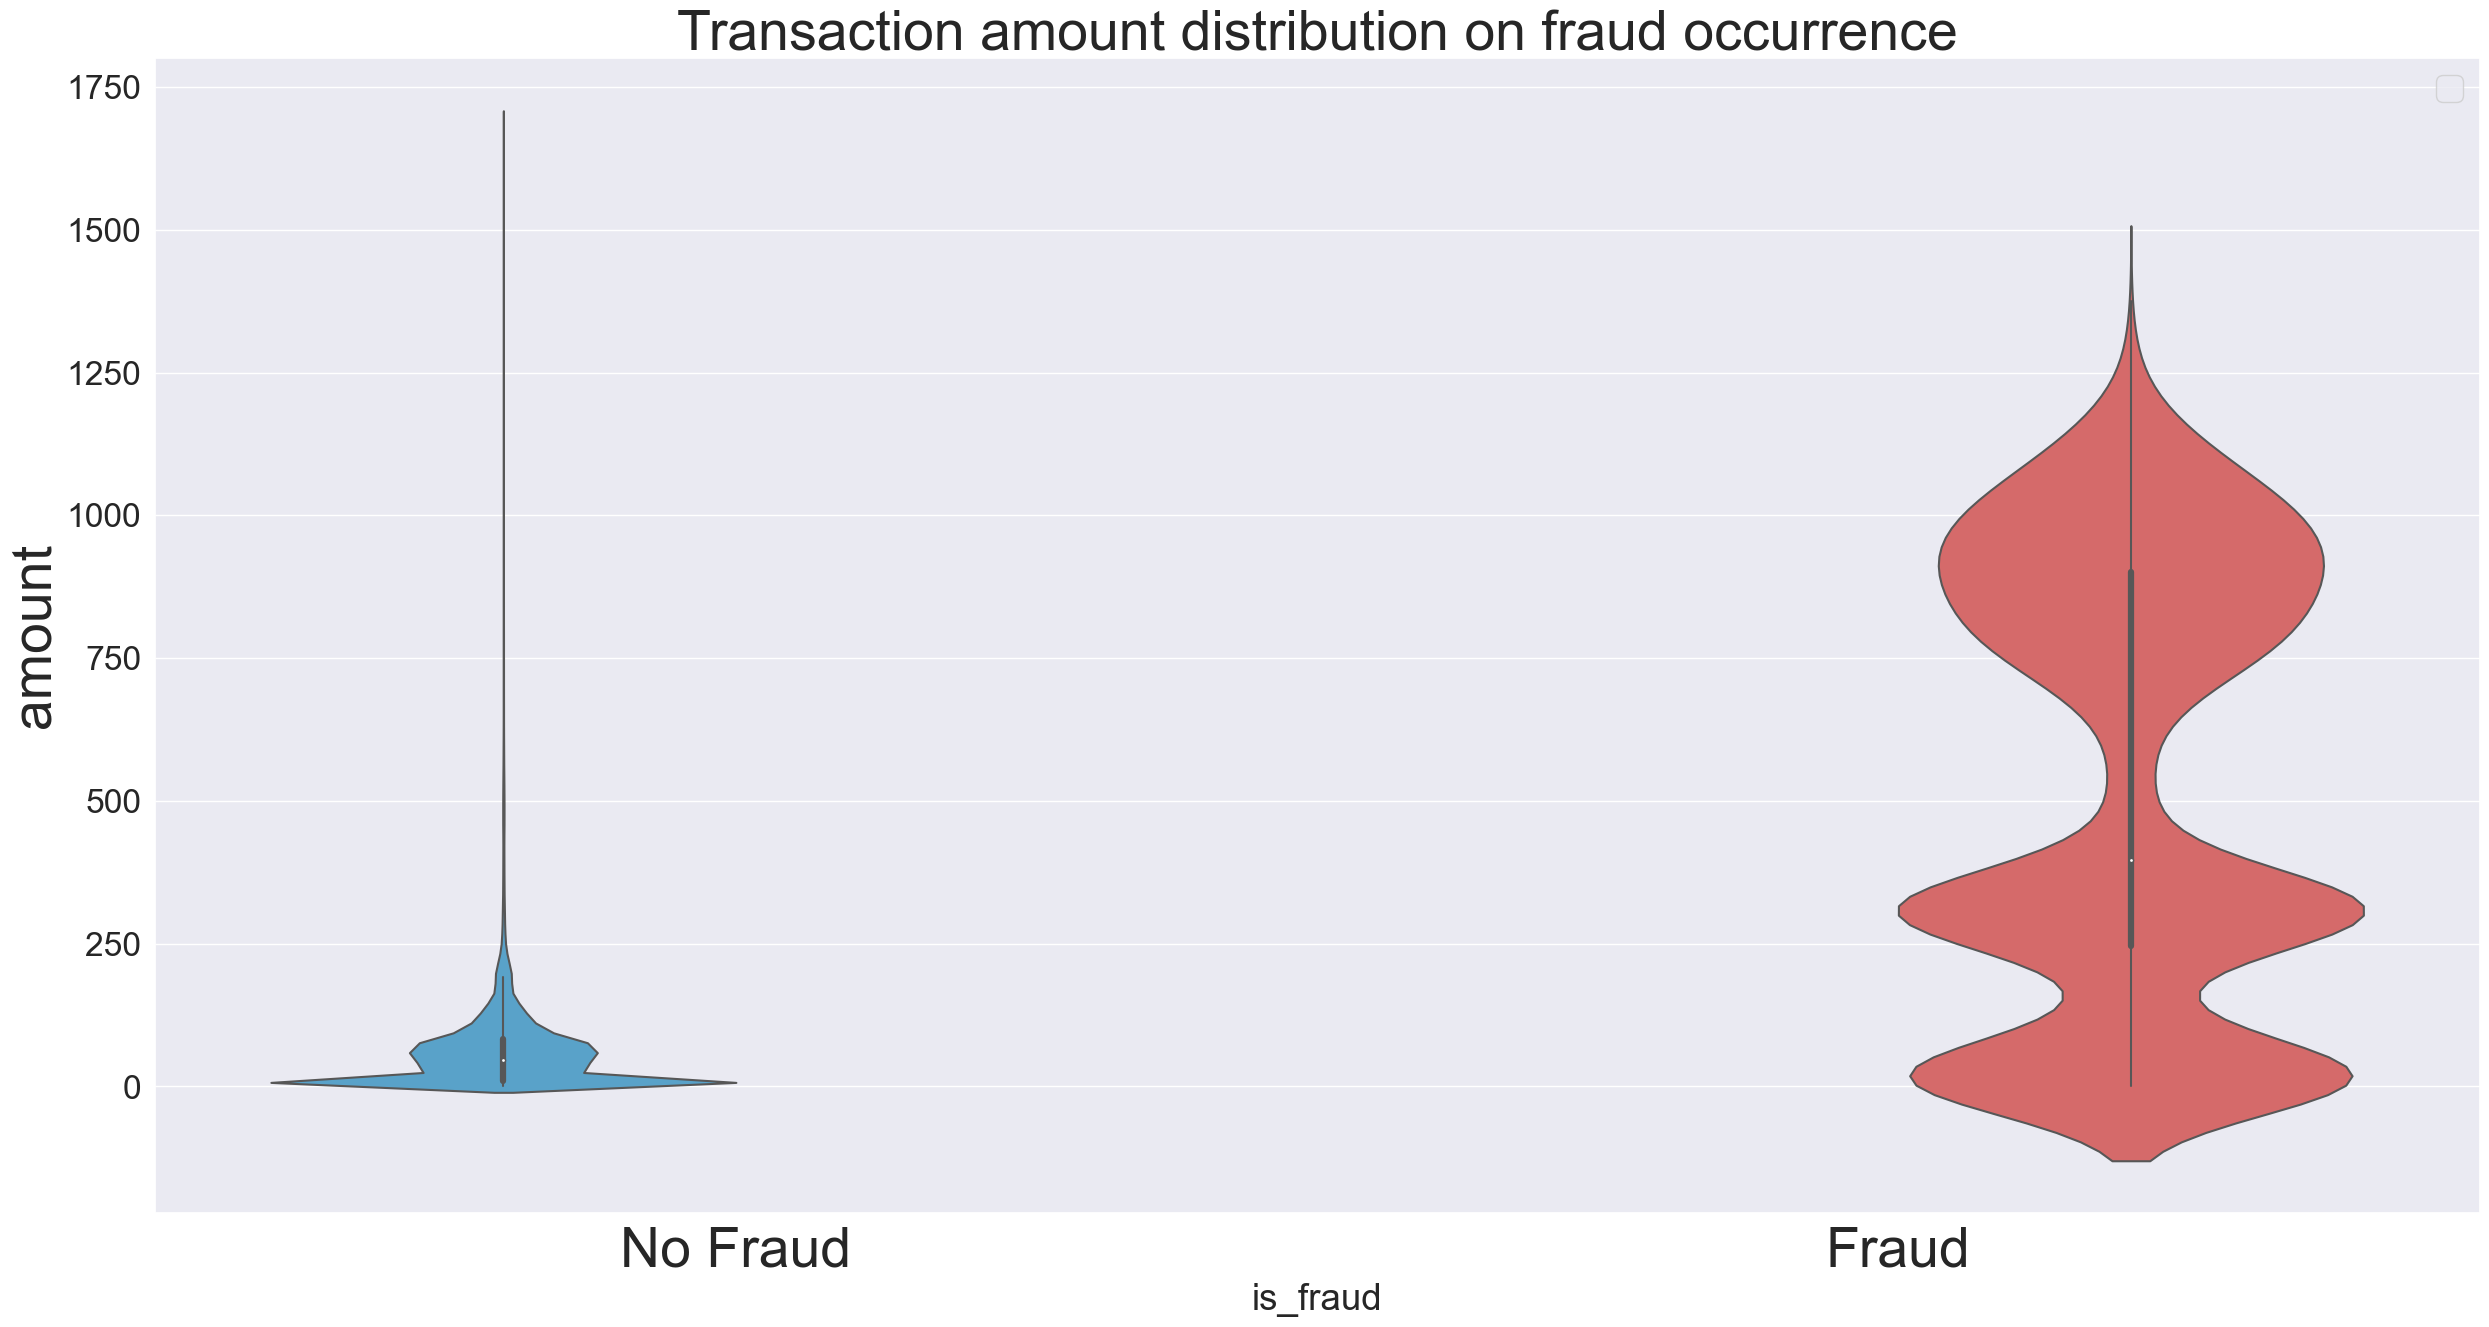

In [8]:
plt.figure(figsize=(30,15))

amt_fraud_df = pd.concat([X_train['amt'], y_train], axis=1)
ax = sns.violinplot(data=amt_fraud_df.loc[amt_fraud_df['amt']<1700,:], x='is_fraud', y='amt', hue='is_fraud', 
                    palette={0: '#46A7DC', 1: "#E75858"})
utils.set_plot_labels(ax, 
                      title=('Transaction amount distribution on fraud occurrence', 40),  
                      ylab=('amount',40))
ax.set_xticklabels(['No Fraud', 'Fraud'], fontsize=40)
ax.legend([])

plt.show()

### 
### 일반거래(왼쪽)와 사기거래(오른쪽)의 연령 분포

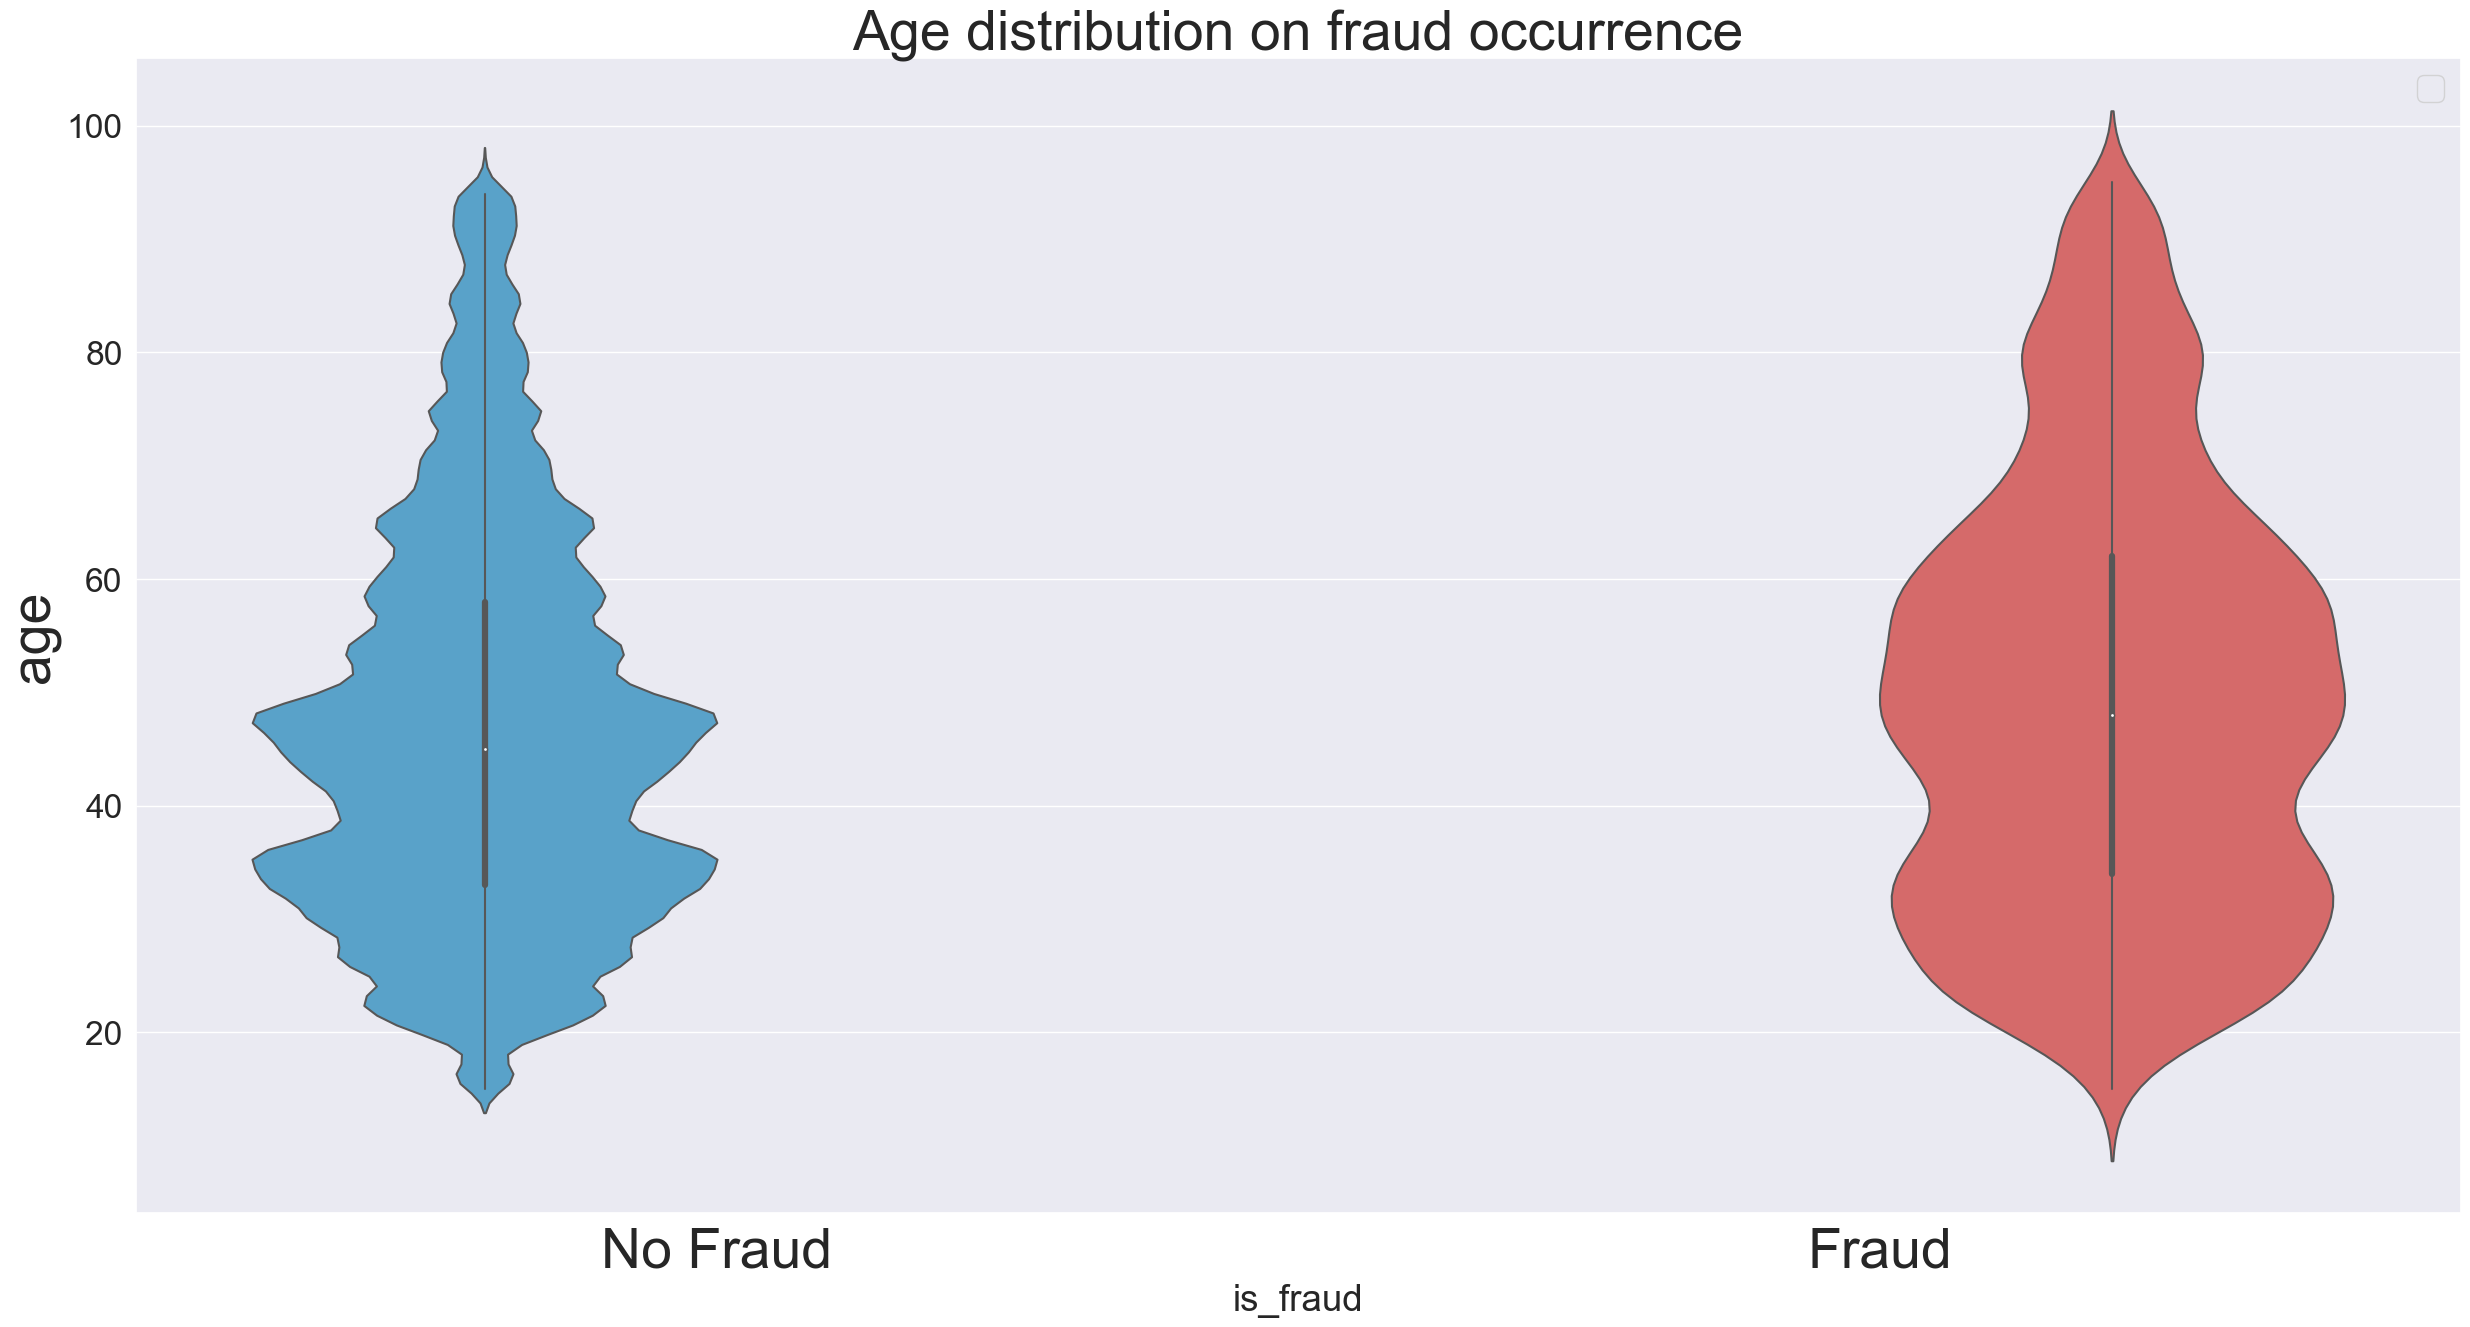

In [9]:
plt.figure(figsize=(30,15))

age_fraud_df = pd.concat([X_train['age'], y_train], axis=1)
ax = sns.violinplot(data=age_fraud_df, x='is_fraud', y='age', hue='is_fraud', 
                    palette={0: '#46A7DC', 1: "#E75858"})
utils.set_plot_labels(ax, 
                      title=('Age distribution on fraud occurrence', 40),  
                      ylab=('age',40))
ax.set_xticklabels(['No Fraud', 'Fraud'], fontsize=40)
ax.legend([])

plt.show()

### 
### 연령대별 신용카드 사기거래(오른쪽)와 일반거래(왼쪽) 추세 분석

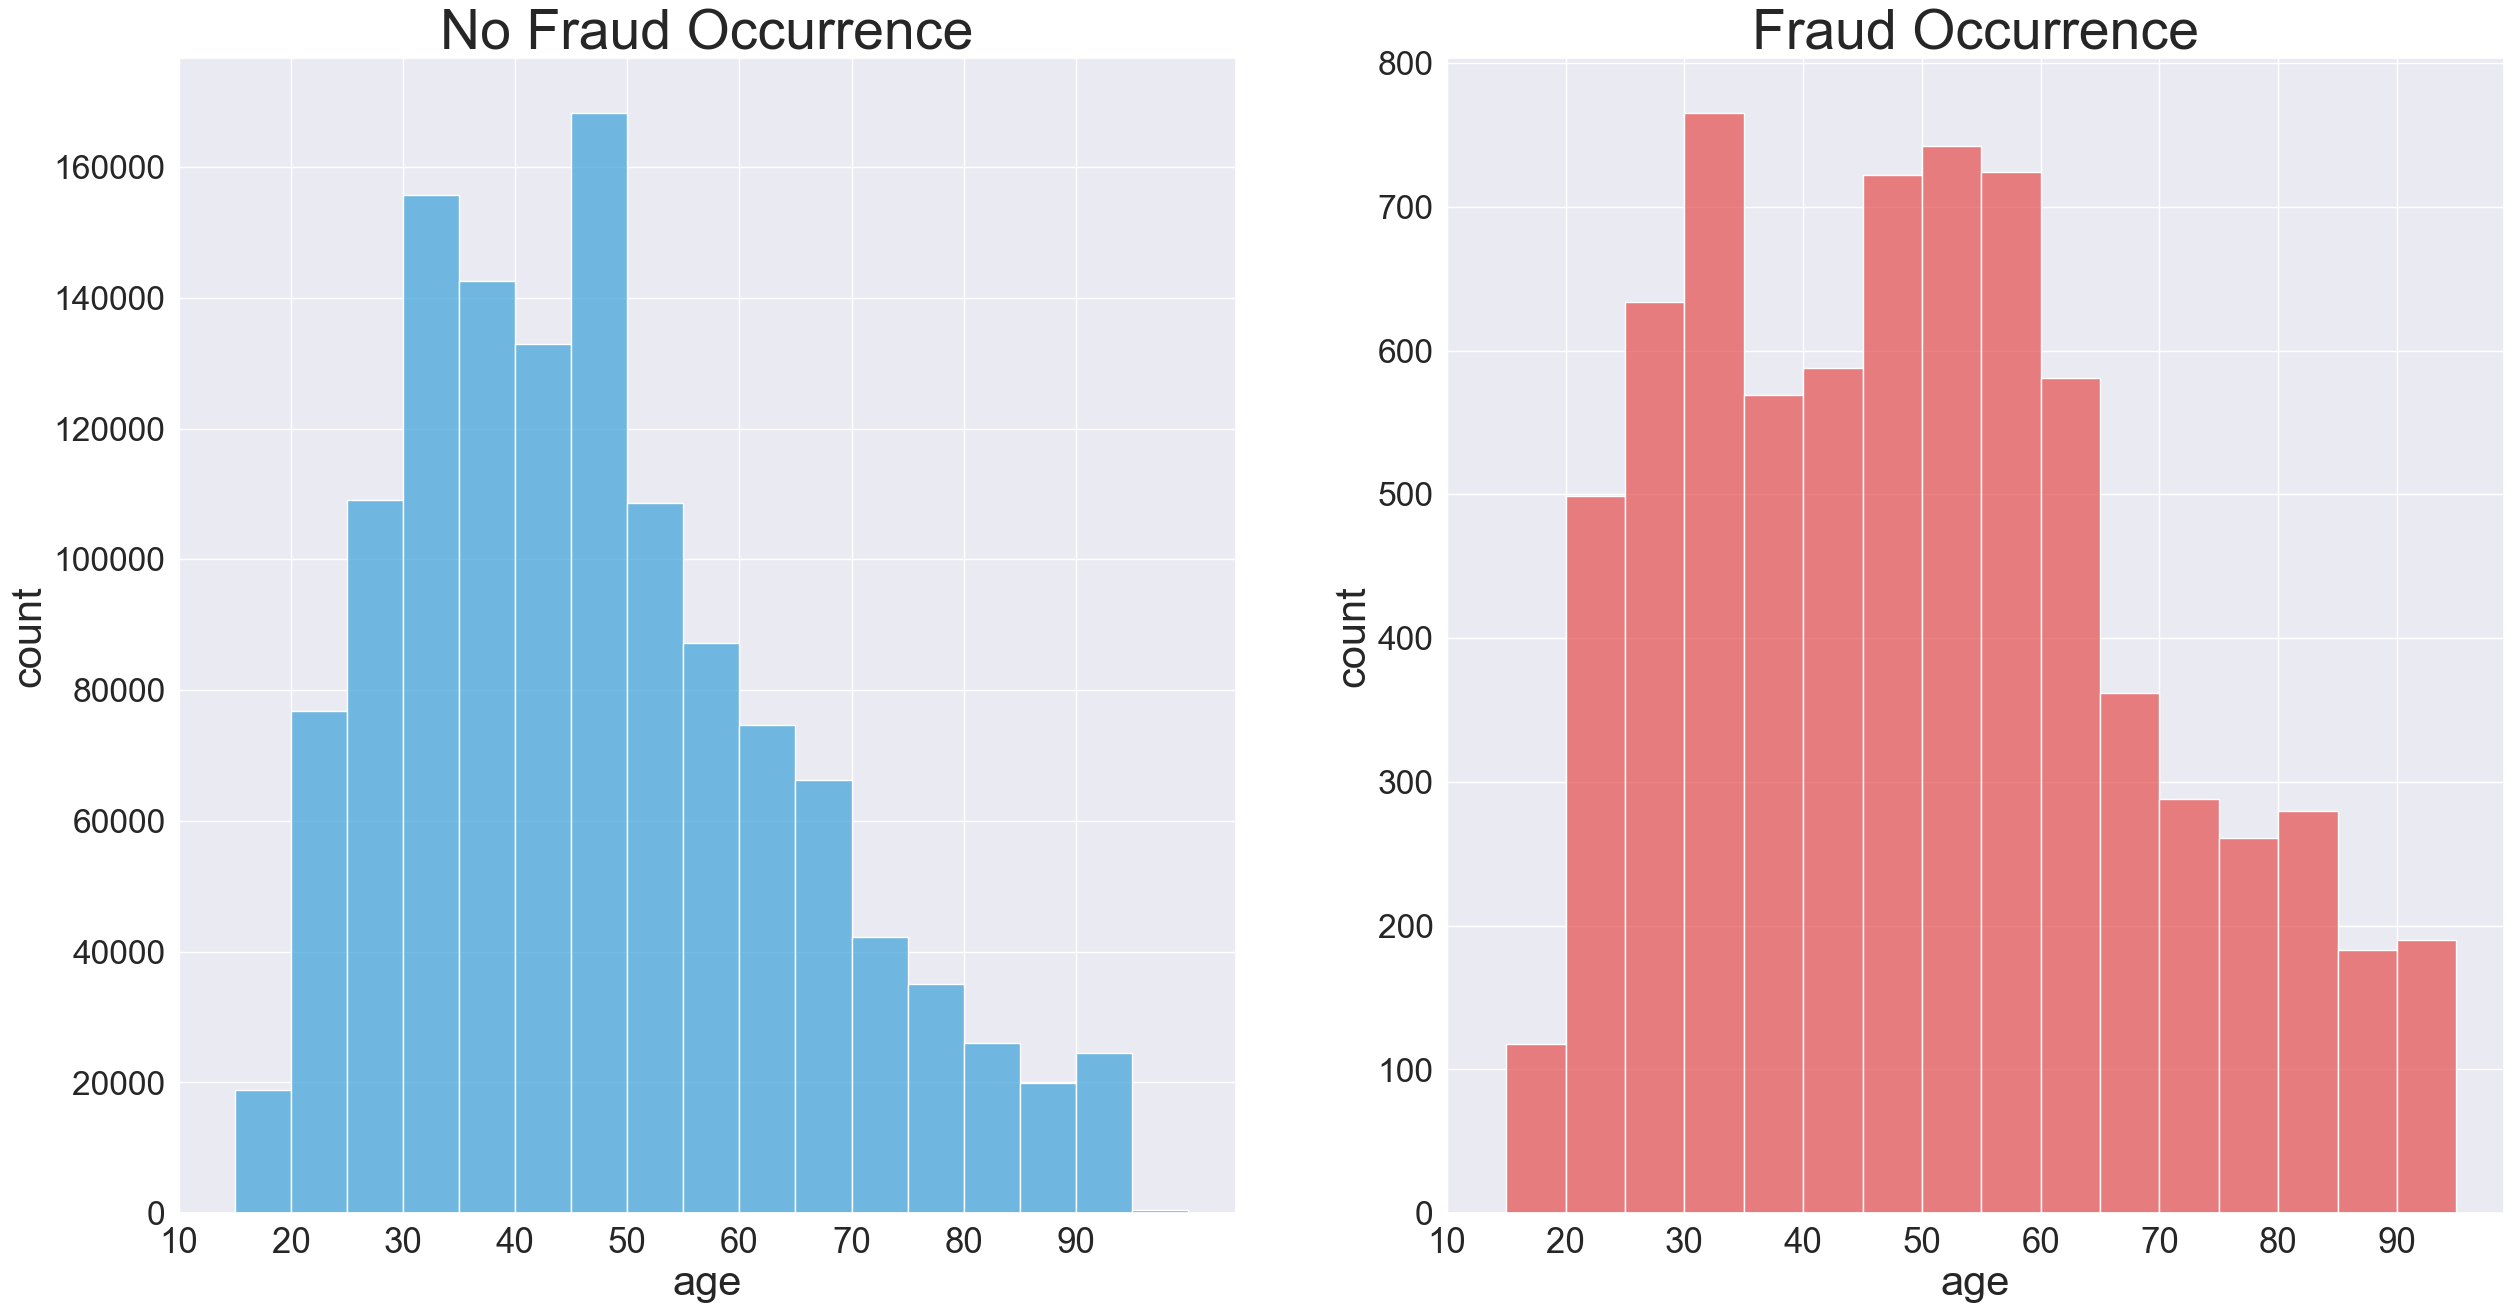

In [10]:
plt.figure(figsize=(30,15))

plt.subplot(1, 2, 1)
ax1 = sns.histplot(x='age',data=X_train.loc[y_train==0,:], common_norm=False, stat='count', multiple='stack', binwidth=5, color='#46A7DC')
ax1 = utils.set_plot_labels(ax1, ('No Fraud Occurrence', 40), ('age',30), ('count',30))
plt.xticks(range(10, 100, 10), size=25)
plt.subplot(1, 2, 2)
ax2 = sns.histplot(x='age',data=X_train.loc[y_train==1,:], common_norm=False, stat='count', multiple='stack', binwidth=5, color="#E75858")
ax2 = utils.set_plot_labels(ax2, ('Fraud Occurrence', 40), ('age',30), ('count',30))
plt.xticks(range(10, 100, 10), size=25)

plt.show()

### 
### 일반거래(왼쪽)와 사기거래(오른쪽)의 발생 시간 분포

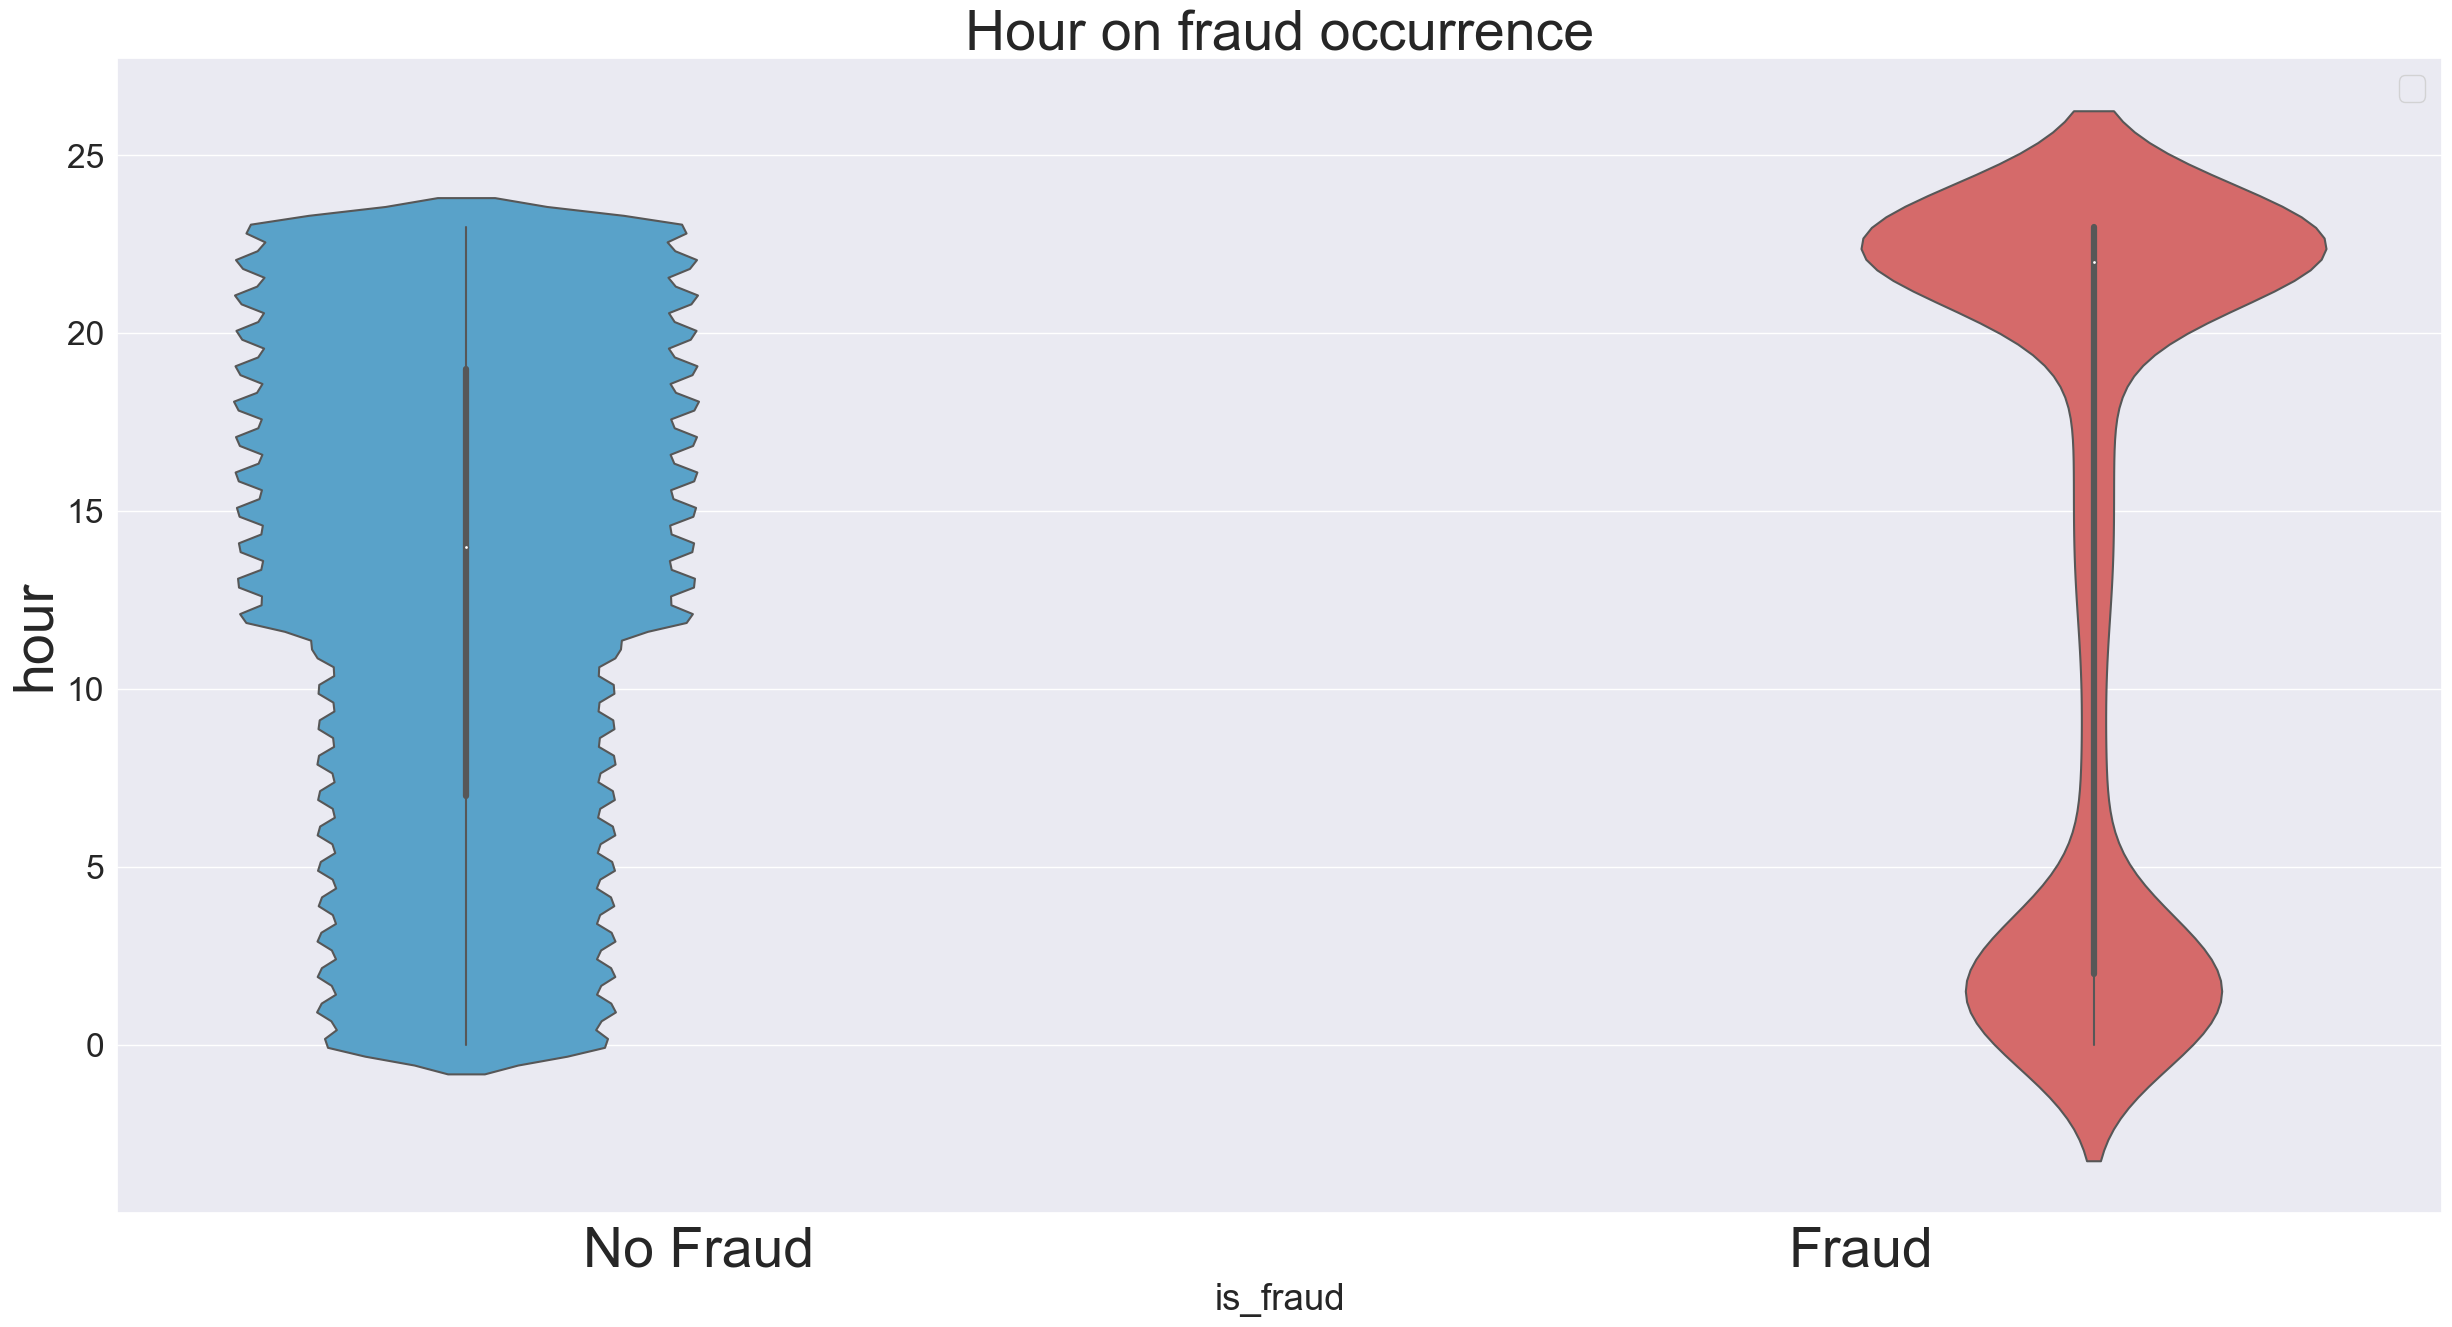

In [11]:
plt.figure(figsize=(30,15))

age_fraud_df = pd.concat([X_train['hour'], y_train], axis=1)
ax = sns.violinplot(data=age_fraud_df, x='is_fraud', y='hour', hue='is_fraud', 
                    palette={0: '#46A7DC', 1: "#E75858"})
utils.set_plot_labels(ax, 
                      title=('Hour on fraud occurrence', 40),  
                      ylab=('hour',40))
ax.set_xticklabels(['No Fraud', 'Fraud'], fontsize=40)
ax.legend([])

plt.show()

### 
### 시간대별 일반거래(위)와 사기거래(아래) 분포

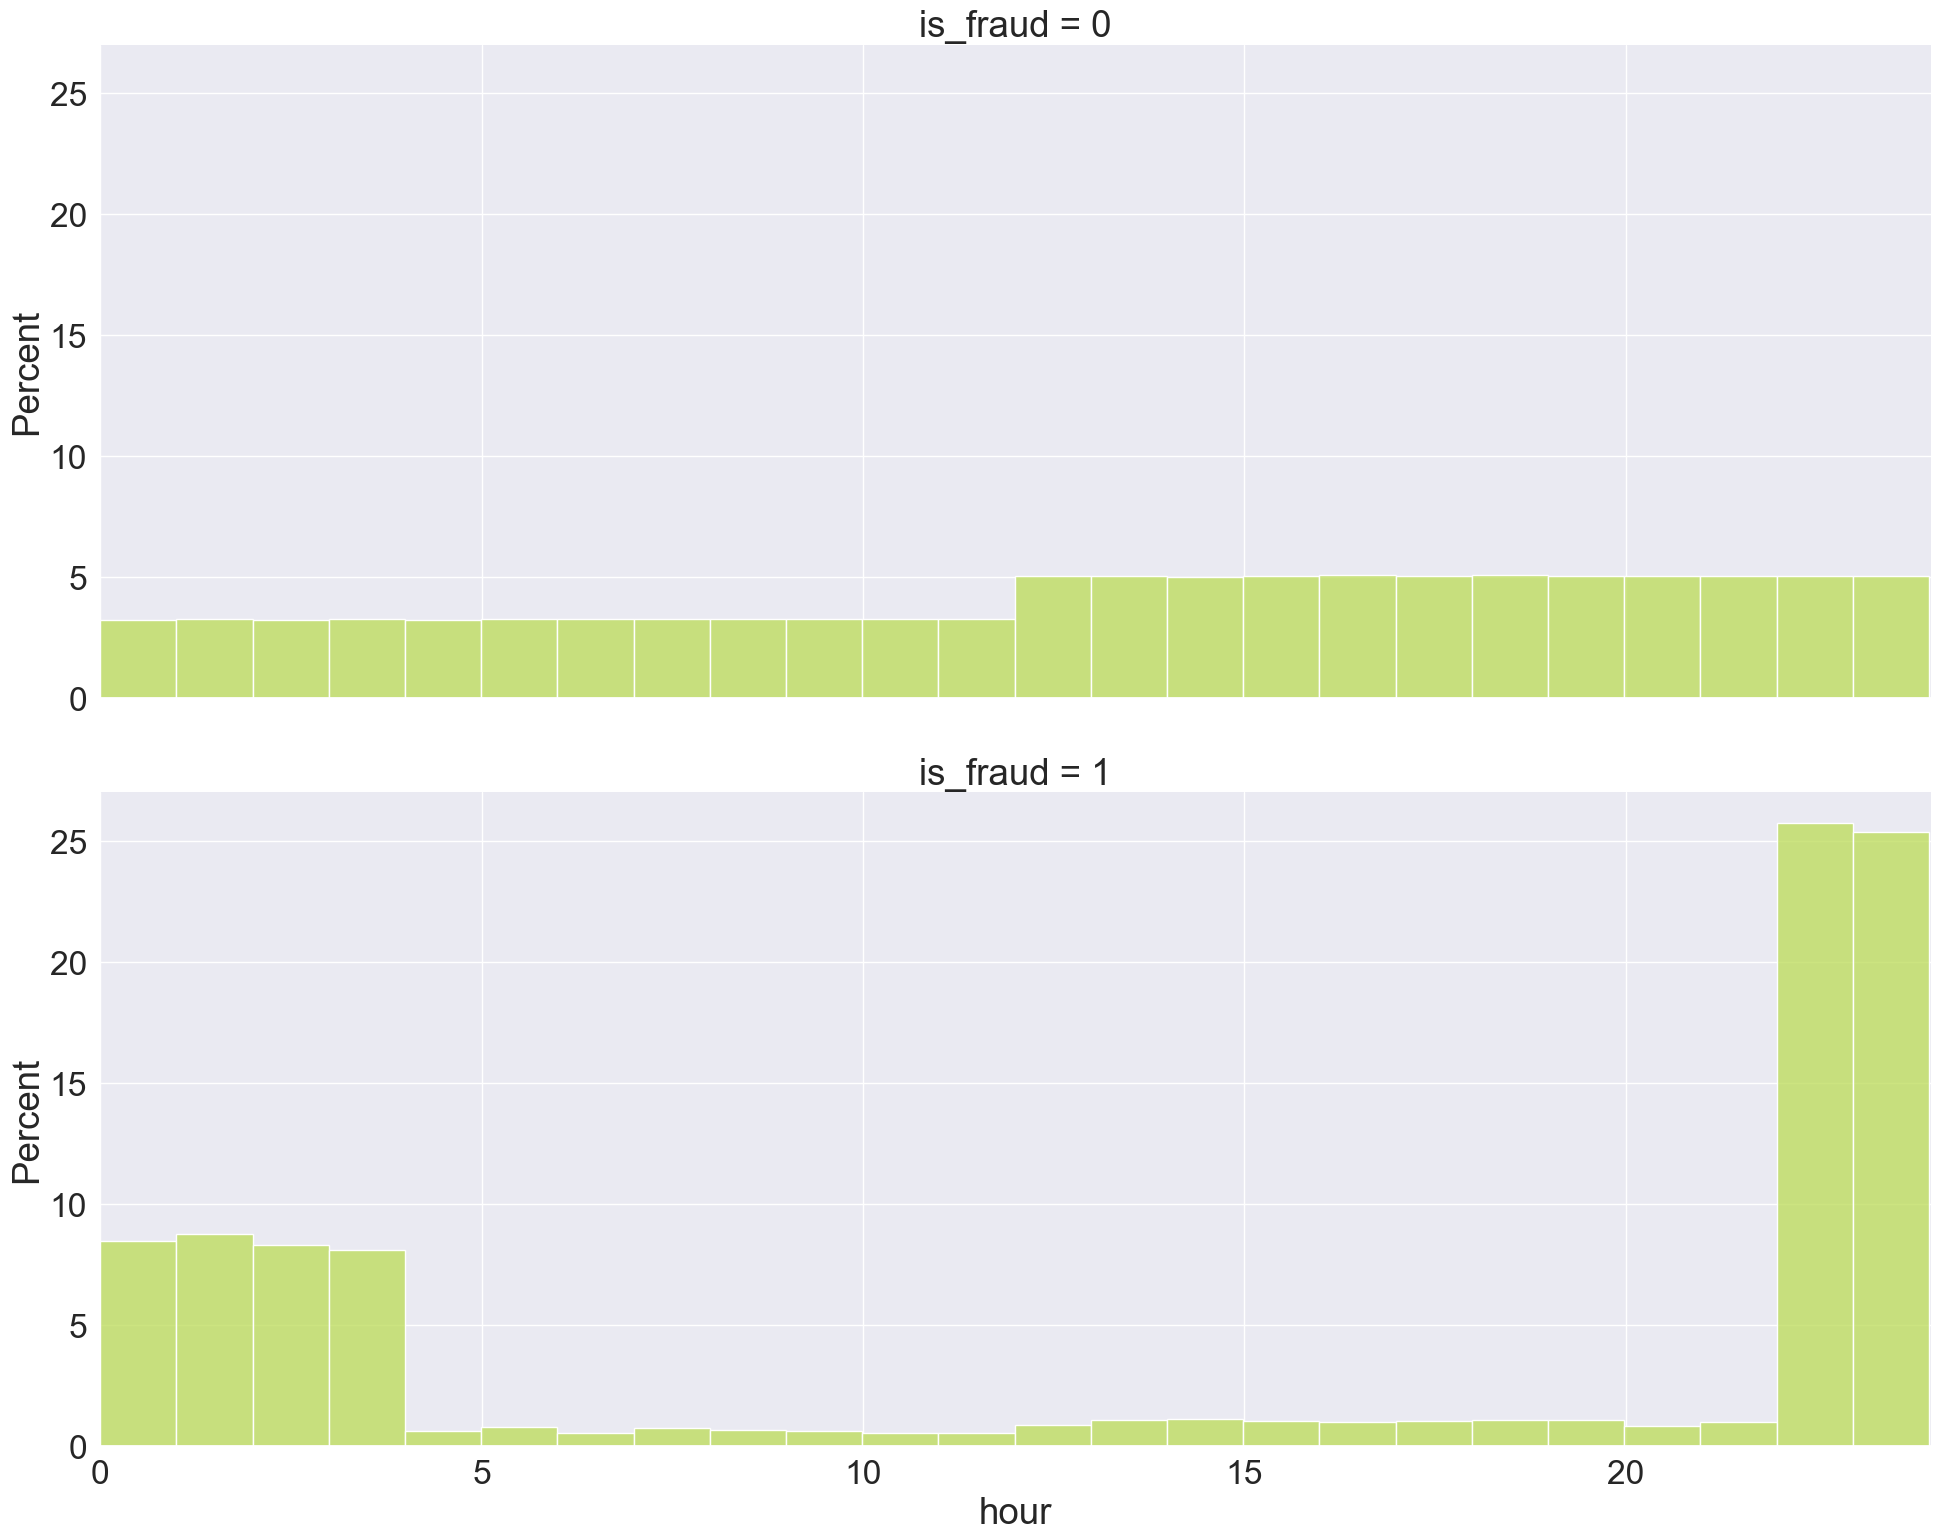

In [12]:
hour_fraud_df = pd.concat([X_train['hour'], y_train], axis=1)
plot = sns.FacetGrid(hour_fraud_df, row='is_fraud', height=8, aspect=2.5, xlim=(0,24))
plot.map(sns.histplot, 'hour', stat='percent', binwidth=0.999, color='#BCDC56')

### 
### 요일별 일반거래(위)와 사기거래(아래) 분포

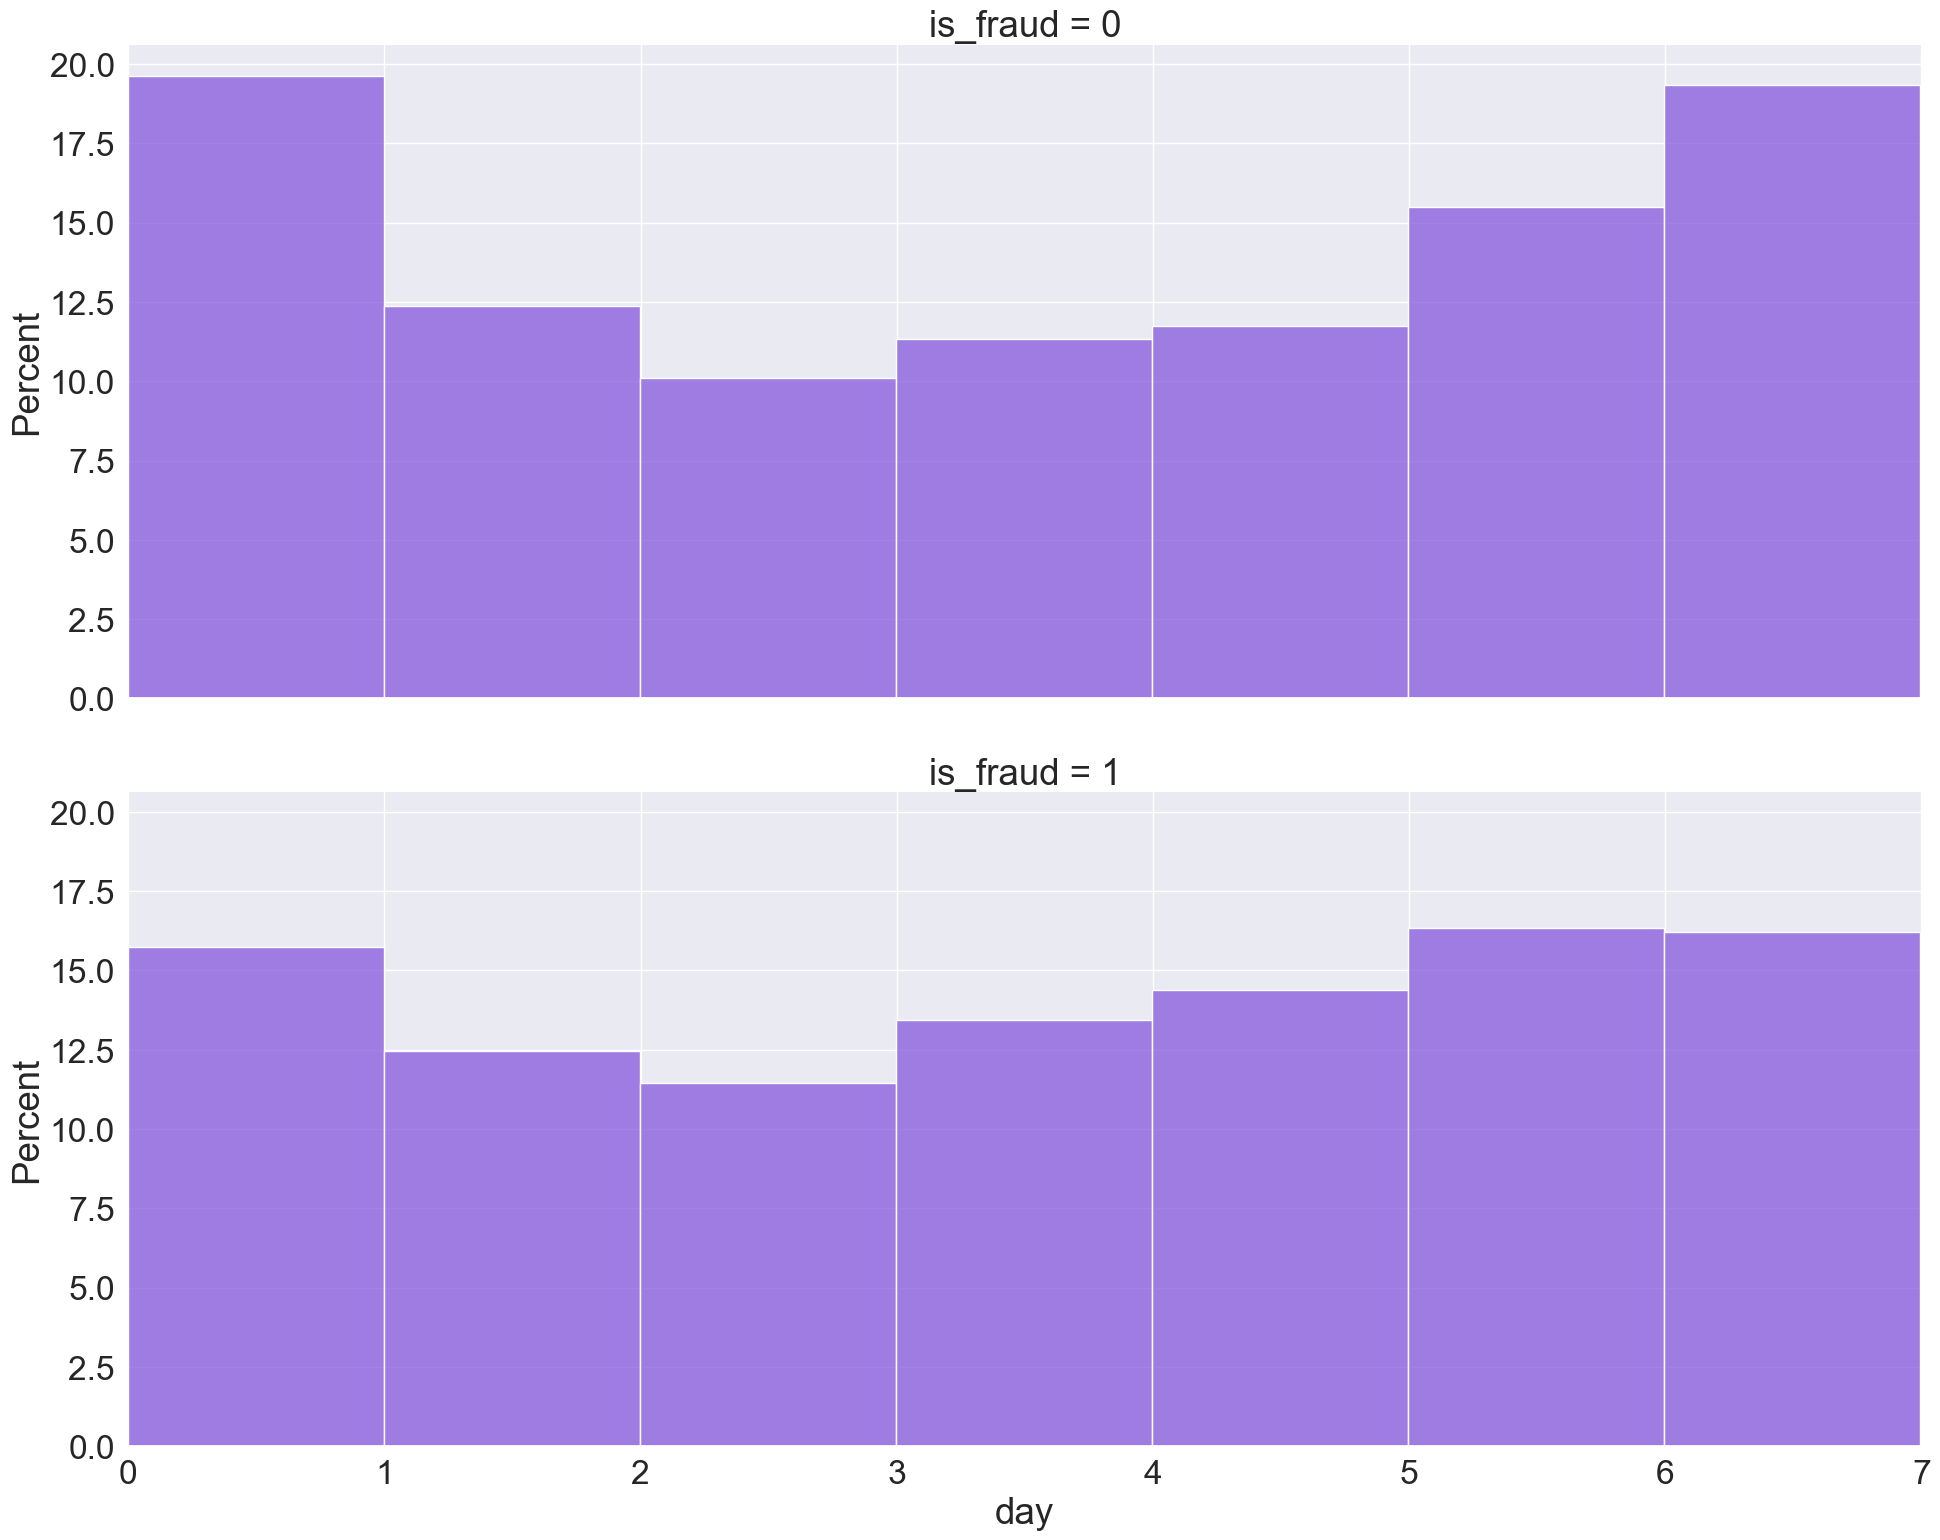

In [13]:
day_fraud_df = pd.concat([X_train['day'], y_train], axis=1)
plot = sns.FacetGrid(day_fraud_df, row='is_fraud', height=8, aspect=2.5, xlim=(0,7))
plot.map(sns.histplot, 'day', stat='percent', binwidth=0.999, color='#8657DC')

### 
### 월별 일반거래(위)와 사기거래(아래) 분포

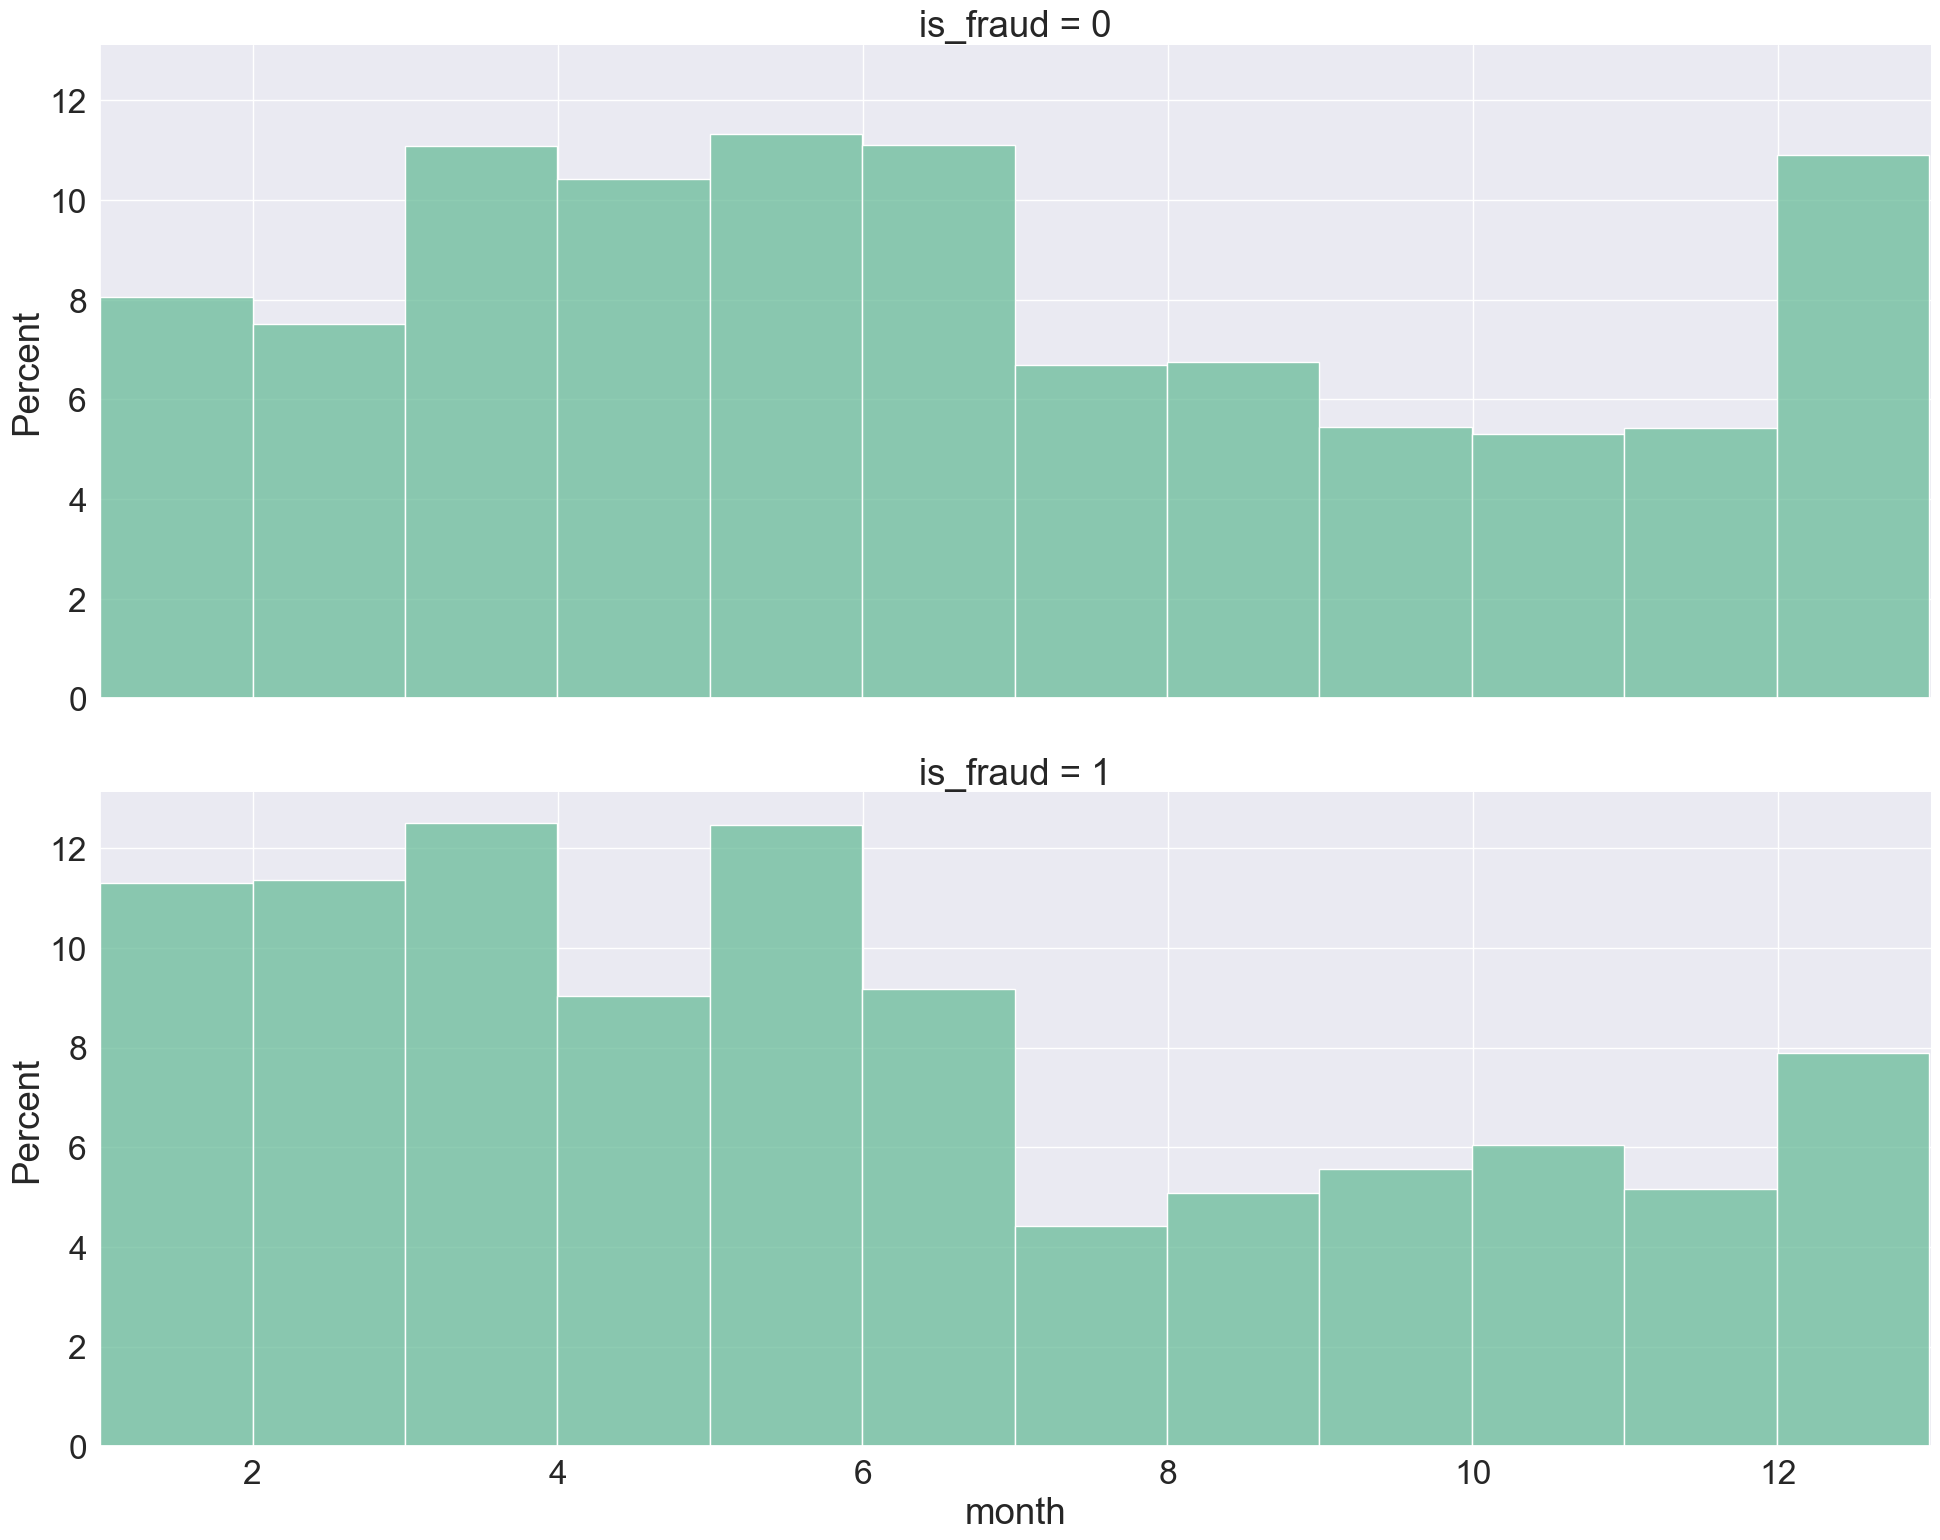

In [14]:
month_fraud_df = pd.concat([X_train['month'], y_train], axis=1)
plot = sns.FacetGrid(month_fraud_df, row='is_fraud', height=8, aspect=2.5, xlim=(1,13))
plot.map(sns.histplot, 'month', stat='percent', binwidth=0.999, color='#69BC99')

### 
### 카드소유주 직업군별 일반거래(위)와 사기거래(아래) 분포

In [15]:
job_cat = datasets.load_job_cat_dataset()

X_train = pd.merge(X_train, job_cat, how = 'left', on = 'job')
X_test = pd.merge(X_test, job_cat, how = 'left', on = 'job')

X_train.loc[0:5, 'job_cat']

0       research/science
1              education
2    military/government
3                    law
4       customer service
5              transport
Name: job_cat, dtype: object

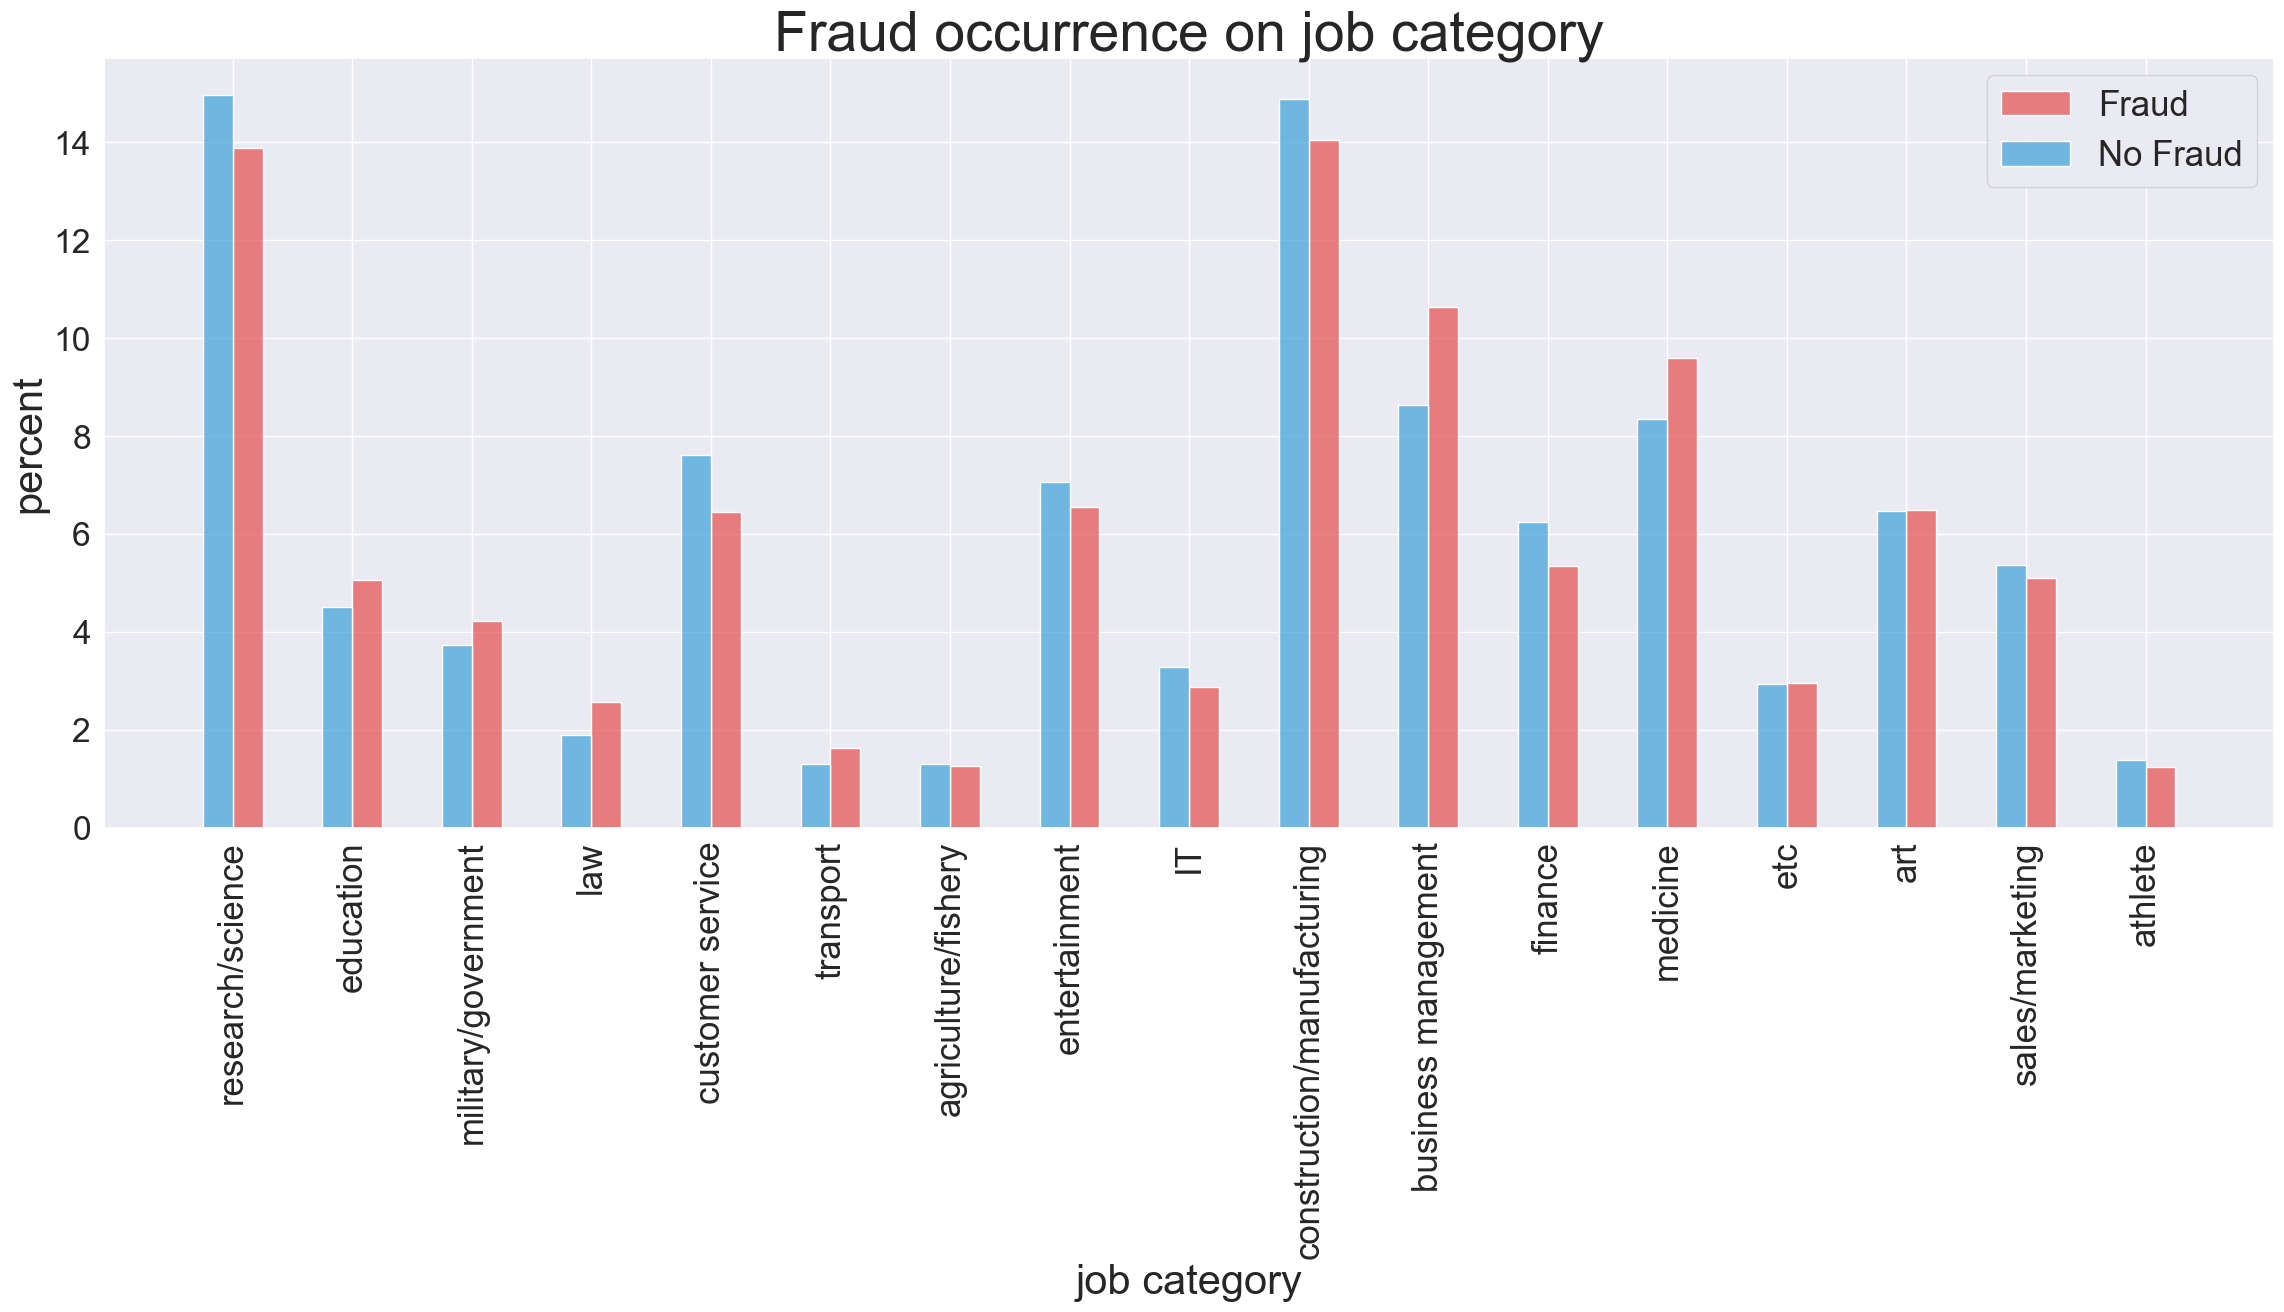

In [16]:
plt.figure(figsize=(28,10))
ax = sns.histplot(data=pd.concat([X_train['job_cat'], y_train], axis=1), 
                  x='job_cat', hue='is_fraud', palette={0: '#46A7DC', 1: "#E75858"},
                  common_norm=False, stat='percent', multiple='dodge', binwidth=1,  shrink= 0.5)
utils.set_plot_labels(ax, 
                      ('Fraud occurrence on job category', 40), 
                      ('job category', 30), 
                      ('percent', 30),
                      (['Fraud', 'No Fraud'], 25))
plt.xticks(size=25, rotation=90)
plt.show()

### 
### 거래 상점그룹별 일반거래(위)와 사기거래(아래) 분포 분석

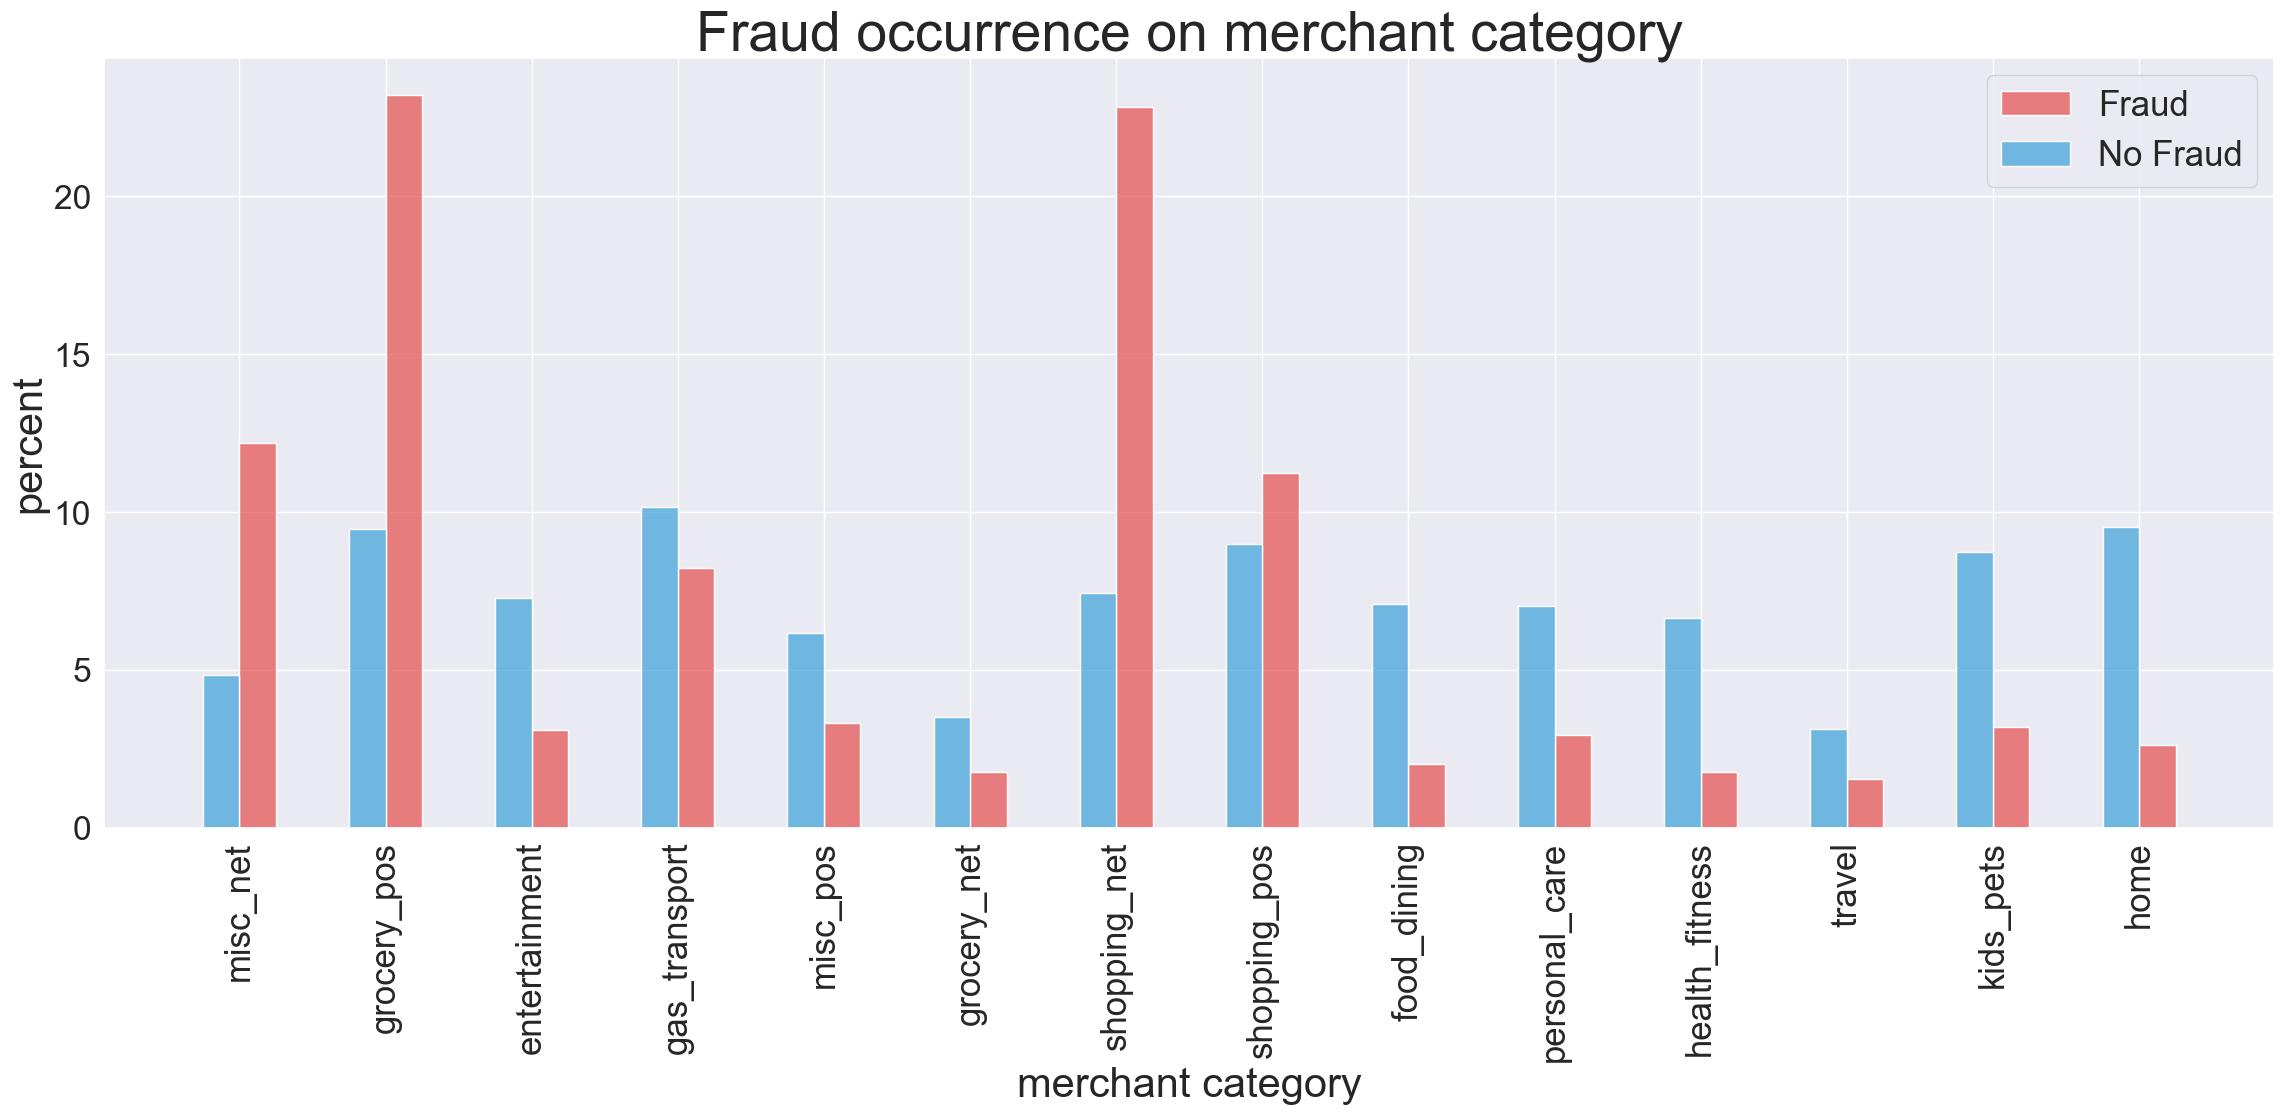

In [17]:
plt.figure(figsize=(28,10))
ax = sns.histplot(data=pd.concat([X_train['merch_cat'], y_train], axis=1), 
                  x='merch_cat', hue='is_fraud', palette={0: '#46A7DC', 1: "#E75858"},
                  common_norm=False, stat='percent', multiple='dodge', binwidth=1,  shrink= 0.5)
utils.set_plot_labels(ax, 
                      ('Fraud occurrence on merchant category', 40),
                      ('merchant category', 30), 
                      ('percent', 30),
                      (['Fraud', 'No Fraud'], 25))
plt.xticks(size=25, rotation=90)
plt.show()

### 
### 공간 데이터 분석

In [18]:
overall_df = pd.concat([X_train, y_train], axis=1)
uniq_fr_cc_num = overall_df.loc[overall_df['is_fraud']==1,:]['cc_num'].unique()

In [19]:
# data frame with a card number of which card was used for fraud at least once
df_w_fraud_card = overall_df.loc[overall_df['cc_num'].isin(uniq_fr_cc_num), :]
# data frame without a card number of which card was used for fraud at least once
df_wo_fraud_card = overall_df.loc[~overall_df['cc_num'].isin(uniq_fr_cc_num), :]

In [20]:
smpld_w_fraud_card = df_w_fraud_card.sample(n=3000, replace=False, random_state=121)
smpld_w_fraud_card.reset_index(inplace=True, drop=True)

smpld_wo_fraud_card = df_wo_fraud_card.sample(n=3000, replace=False, random_state=121)
smpld_wo_fraud_card.reset_index(inplace=True, drop=True)

In [21]:
fraud_map = utils.get_map_with_markers(smpld_w_fraud_card, 'merch_lat', 'merch_long')
no_fraud_map = utils.get_map_with_markers(smpld_wo_fraud_card, 'merch_lat', 'merch_long')

In [22]:
fraud_map

In [23]:
no_fraud_map

### 
### 이상치 제거

In [24]:
amt_threshold = 1700
print(sum(y_train[X_train['amt'] >= amt_threshold])) # 이상치 제거로 인한 사기거래:1 행 제거 갯수 = 0

y_train = y_train[X_train['amt'] < amt_threshold]
X_train = X_train.loc[X_train['amt'] < amt_threshold, :]

X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

0


### 
### 거래 상호 카테고리 원-핫 인코딩

<hr>

# 
# 3. 예측 모델을 위한 Feature 선택

1. merchant_cat을 예측에 활용하기 위해 원-핫 인코딩
2. EDA를 통해 Key Feature(hour, age, merchant_cat 원-핫 벡터, amt 등)를 남기고 불필요한 Feature제거

In [25]:
# 원핫 인코딩
X_train = utils.get_new_df_with_onehot_encoding(X_train, 'merch_cat', True)
X_test = utils.get_new_df_with_onehot_encoding(X_test, 'merch_cat', False)

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295690 entries, 0 to 1295689
Data columns (total 39 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   trans_time                1295690 non-null  datetime64[ns]
 1   cc_num                    1295690 non-null  int64         
 2   merchant                  1295690 non-null  object        
 3   amt                       1295690 non-null  float64       
 4   first                     1295690 non-null  object        
 5   last                      1295690 non-null  object        
 6   gender                    1295690 non-null  int64         
 7   street                    1295690 non-null  object        
 8   city                      1295690 non-null  object        
 9   state                     1295690 non-null  object        
 10  zip                       1295690 non-null  int64         
 11  lat                       1295690 non-null  float6

In [27]:
unuse_cols = ["trans_time", "cc_num", "merchant", "first", "last", "gender", "street", "city", "state", "zip",
               "lat", "long", "city_pop", "job", "dob", "trans_num", "unix_time", "month", "job_cat"]

X_train.drop(columns=unuse_cols, inplace=True)
X_test.drop(columns=unuse_cols, inplace=True)

<hr>

# 
# 4. 데이터 불균형 문제 해결

전체 데이터의 약 0.58%만 사기거래 데이터로 굉장히 불균형상태이므로 리샘플링을 통해 불균형 문제를 어느정도 해소 

In [28]:
len(y_train[y_train==1])

7506

In [29]:
len(y_train[y_train==1]) / len(y_train) * 100

0.579305235048507

### 
### 랜덤 포레스트, XGBoost

In [30]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

### 
### 리샘플링 없이 학습

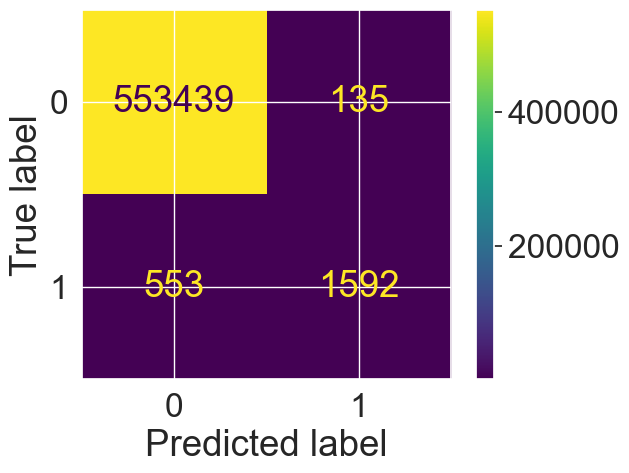

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.74      0.82      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.87      0.91    555719
weighted avg       1.00      1.00      1.00    555719



In [97]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_preds = [1 if x > 0.5 else 0 for x in rfc.predict(X_test)]
utils.print_eval_metrics(y_test, y_preds)

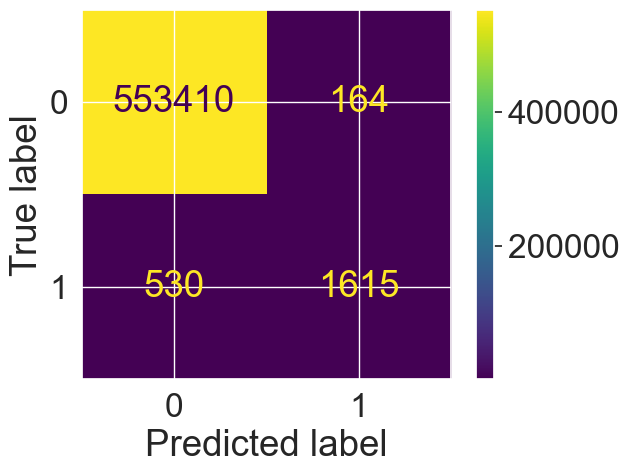

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.91      0.75      0.82      2145

    accuracy                           1.00    555719
   macro avg       0.95      0.88      0.91    555719
weighted avg       1.00      1.00      1.00    555719



In [98]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
y_preds = xgb_model.predict(X_test)
utils.print_eval_metrics(y_test, y_preds)

## 
## 리샘플링

In [31]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

### 
### 언더샘플링

In [32]:
X_train_under, y_train_under = RandomUnderSampler(random_state=0).fit_resample(X_train, y_train)

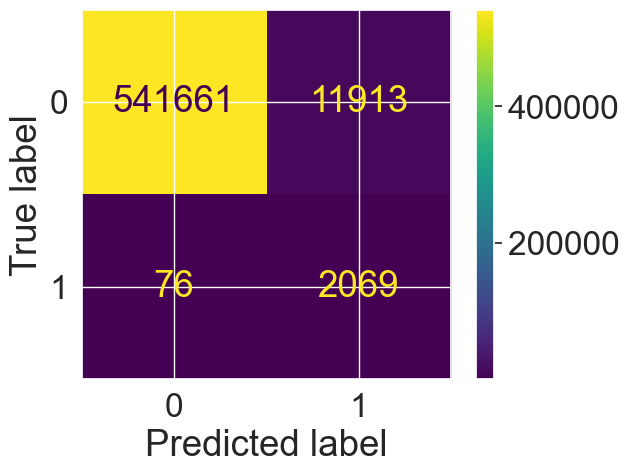

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.15      0.96      0.26      2145

    accuracy                           0.98    555719
   macro avg       0.57      0.97      0.62    555719
weighted avg       1.00      0.98      0.99    555719



In [101]:
rfc = RandomForestClassifier()
rfc.fit(X_train_under, y_train_under)
y_preds = [1 if x > 0.5 else 0 for x in rfc.predict(X_test)]
utils.print_eval_metrics(y_test, y_preds)

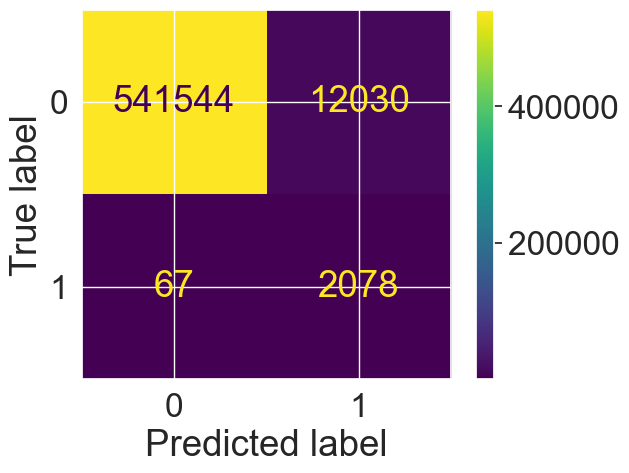

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.15      0.97      0.26      2145

    accuracy                           0.98    555719
   macro avg       0.57      0.97      0.62    555719
weighted avg       1.00      0.98      0.99    555719



In [104]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_under, y_train_under)
y_preds = xgb_model.predict(X_test)
utils.print_eval_metrics(y_test, y_preds)

### 
### 오버샘플링

In [105]:
X_train_over, y_train_over = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)

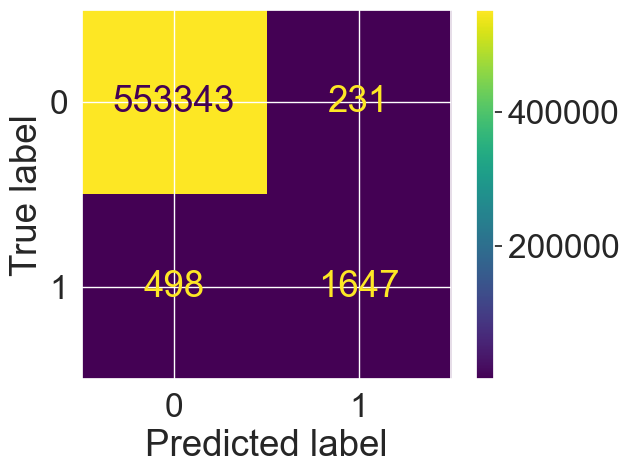

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.88      0.77      0.82      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.88      0.91    555719
weighted avg       1.00      1.00      1.00    555719



In [106]:
rfc = RandomForestClassifier()
rfc.fit(X_train_over, y_train_over)
y_preds = [1 if x > 0.5 else 0 for x in rfc.predict(X_test)]
utils.print_eval_metrics(y_test, y_preds)

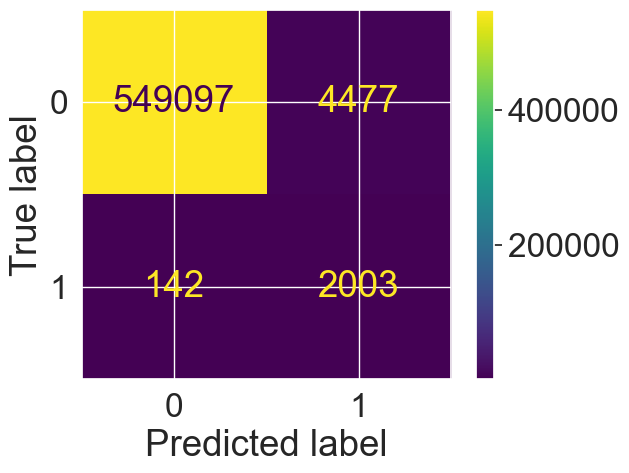

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.31      0.93      0.46      2145

    accuracy                           0.99    555719
   macro avg       0.65      0.96      0.73    555719
weighted avg       1.00      0.99      0.99    555719



In [107]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_over, y_train_over)
y_preds = xgb_model.predict(X_test)
utils.print_eval_metrics(y_test, y_preds)

### 
### SMOTE 오버샘플링

In [108]:
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

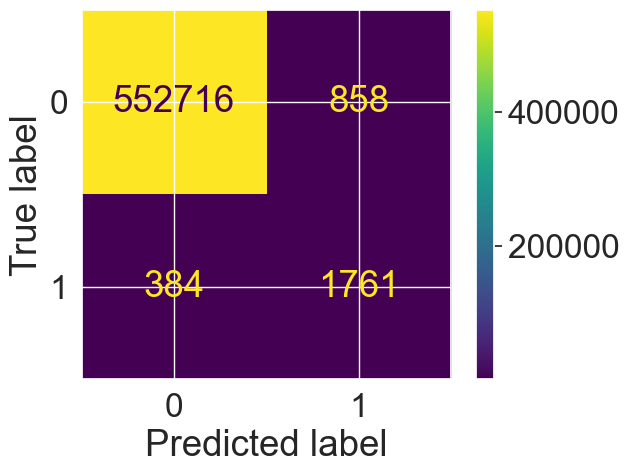

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.67      0.82      0.74      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.91      0.87    555719
weighted avg       1.00      1.00      1.00    555719



In [109]:
rfc = RandomForestClassifier()
rfc.fit(X_train_smote, y_train_smote)
y_preds = [1 if x>0.5 else 0 for x in rfc.predict(X_test)]
utils.print_eval_metrics(y_test, y_preds)

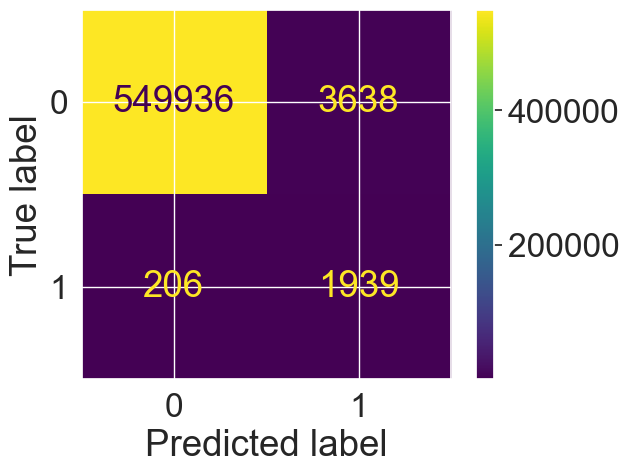

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.35      0.90      0.50      2145

    accuracy                           0.99    555719
   macro avg       0.67      0.95      0.75    555719
weighted avg       1.00      0.99      0.99    555719



In [110]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_smote, y_train_smote)
y_preds = xgb_model.predict(X_test)
utils.print_eval_metrics(y_test, y_preds)

<hr>

# 
# 5. 모델 선정 및 학습

재현율이 가장 중요한 평가 지표이고 앞서 언더샘플링에서 가장 좋은 결과를 보임
<br>
XGBoostClassifier 모델을 가지고 최적 하이퍼파라미터를 찾가위해 언더샘플링과 SMOTE오버샘플링에서 각각 GridSearchCV를 실행

In [43]:
from sklearn.model_selection import GridSearchCV

### 
### GridSearchCV

In [50]:
xgb_clf= xgb.XGBClassifier()

params={
    'n_estimators' : [100,200,300],
    'learning_rate' : [0.01,0.1],
    'max_depth' : [3,7,10],
    'gamma' : [0,1,2],
    'colsample_bytree' : [0.8,0.9], 
}

In [51]:
grid_search_model = GridSearchCV(xgb_clf, param_grid = params, scoring="recall", n_jobs=-1, verbose = 2)
grid_search_model.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9], 'gamma': [0, 1, 2],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 7, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='recall', verbose=2)

In [52]:
grid_search_model.best_params_

{'colsample_bytree': 0.9,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 300}

In [53]:
grid_search_model.best_score_

0.9996840515317063

In [111]:
xgb_clf= xgb.XGBClassifier()
grid_search_model_under = GridSearchCV(xgb_clf, param_grid = params, scoring="recall", n_jobs=-1, verbose = 2, cv = 4)
grid_search_model_under.fit(X_train_under, y_train_under)

Fitting 4 folds for each of 108 candidates, totalling 432 fits


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9], 'gamma': [0, 1, 2],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 7, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='recall', verbose=2)

In [112]:
print(grid_search_model_under.best_params_)
print(grid_search_model_under.best_score_)

{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
0.9773505985939092


<hr>

# 
# 6. 결과

### 
### 최적 하이퍼파라미터로 학습 후 데스트 데이터셋으로 평가
#### SMOTE 오버샘플링과 언더샘플링된 데이터를 가지고 각각 테스트 실행
<br>

#### SMOTE 오버샘플링 + XGBoostClassifier

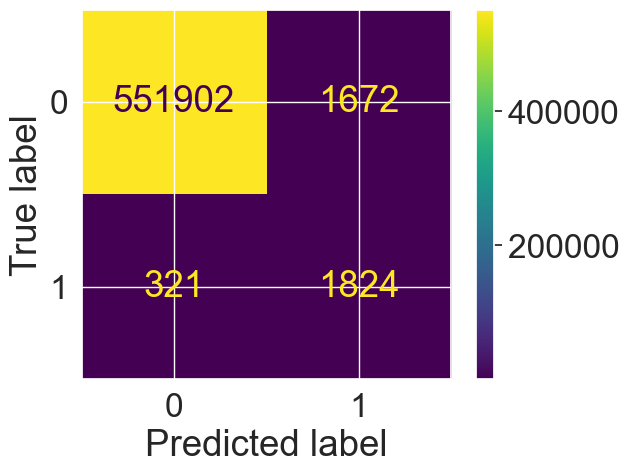

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.52      0.85      0.65      2145

    accuracy                           1.00    555719
   macro avg       0.76      0.92      0.82    555719
weighted avg       1.00      1.00      1.00    555719



In [114]:
xgb__opt_model = xgb.XGBClassifier(colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=300)
xgb__opt_model.fit(X_train_smote, y_train_smote)
y_preds = xgb__opt_model.predict(X_test)
utils.print_eval_metrics(y_test, y_preds)

#### 언더샘플링 + XGBoostClassifier

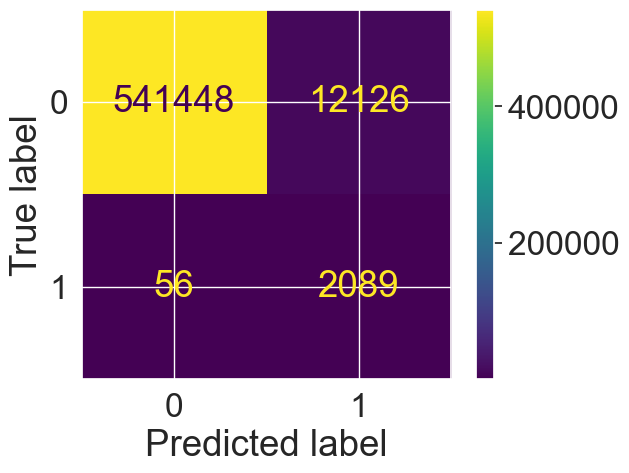

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.15      0.97      0.26      2145

    accuracy                           0.98    555719
   macro avg       0.57      0.98      0.62    555719
weighted avg       1.00      0.98      0.99    555719



In [32]:
X_train_under, y_train_under = RandomUnderSampler(random_state=0).fit_resample(X_train, y_train)
xgb__opt_model_under = xgb.XGBClassifier(colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100)
xgb__opt_model_under.fit(X_train_under, y_train_under)
y_preds = xgb__opt_model_under.predict(X_test)
utils.print_eval_metrics(y_test, y_preds)

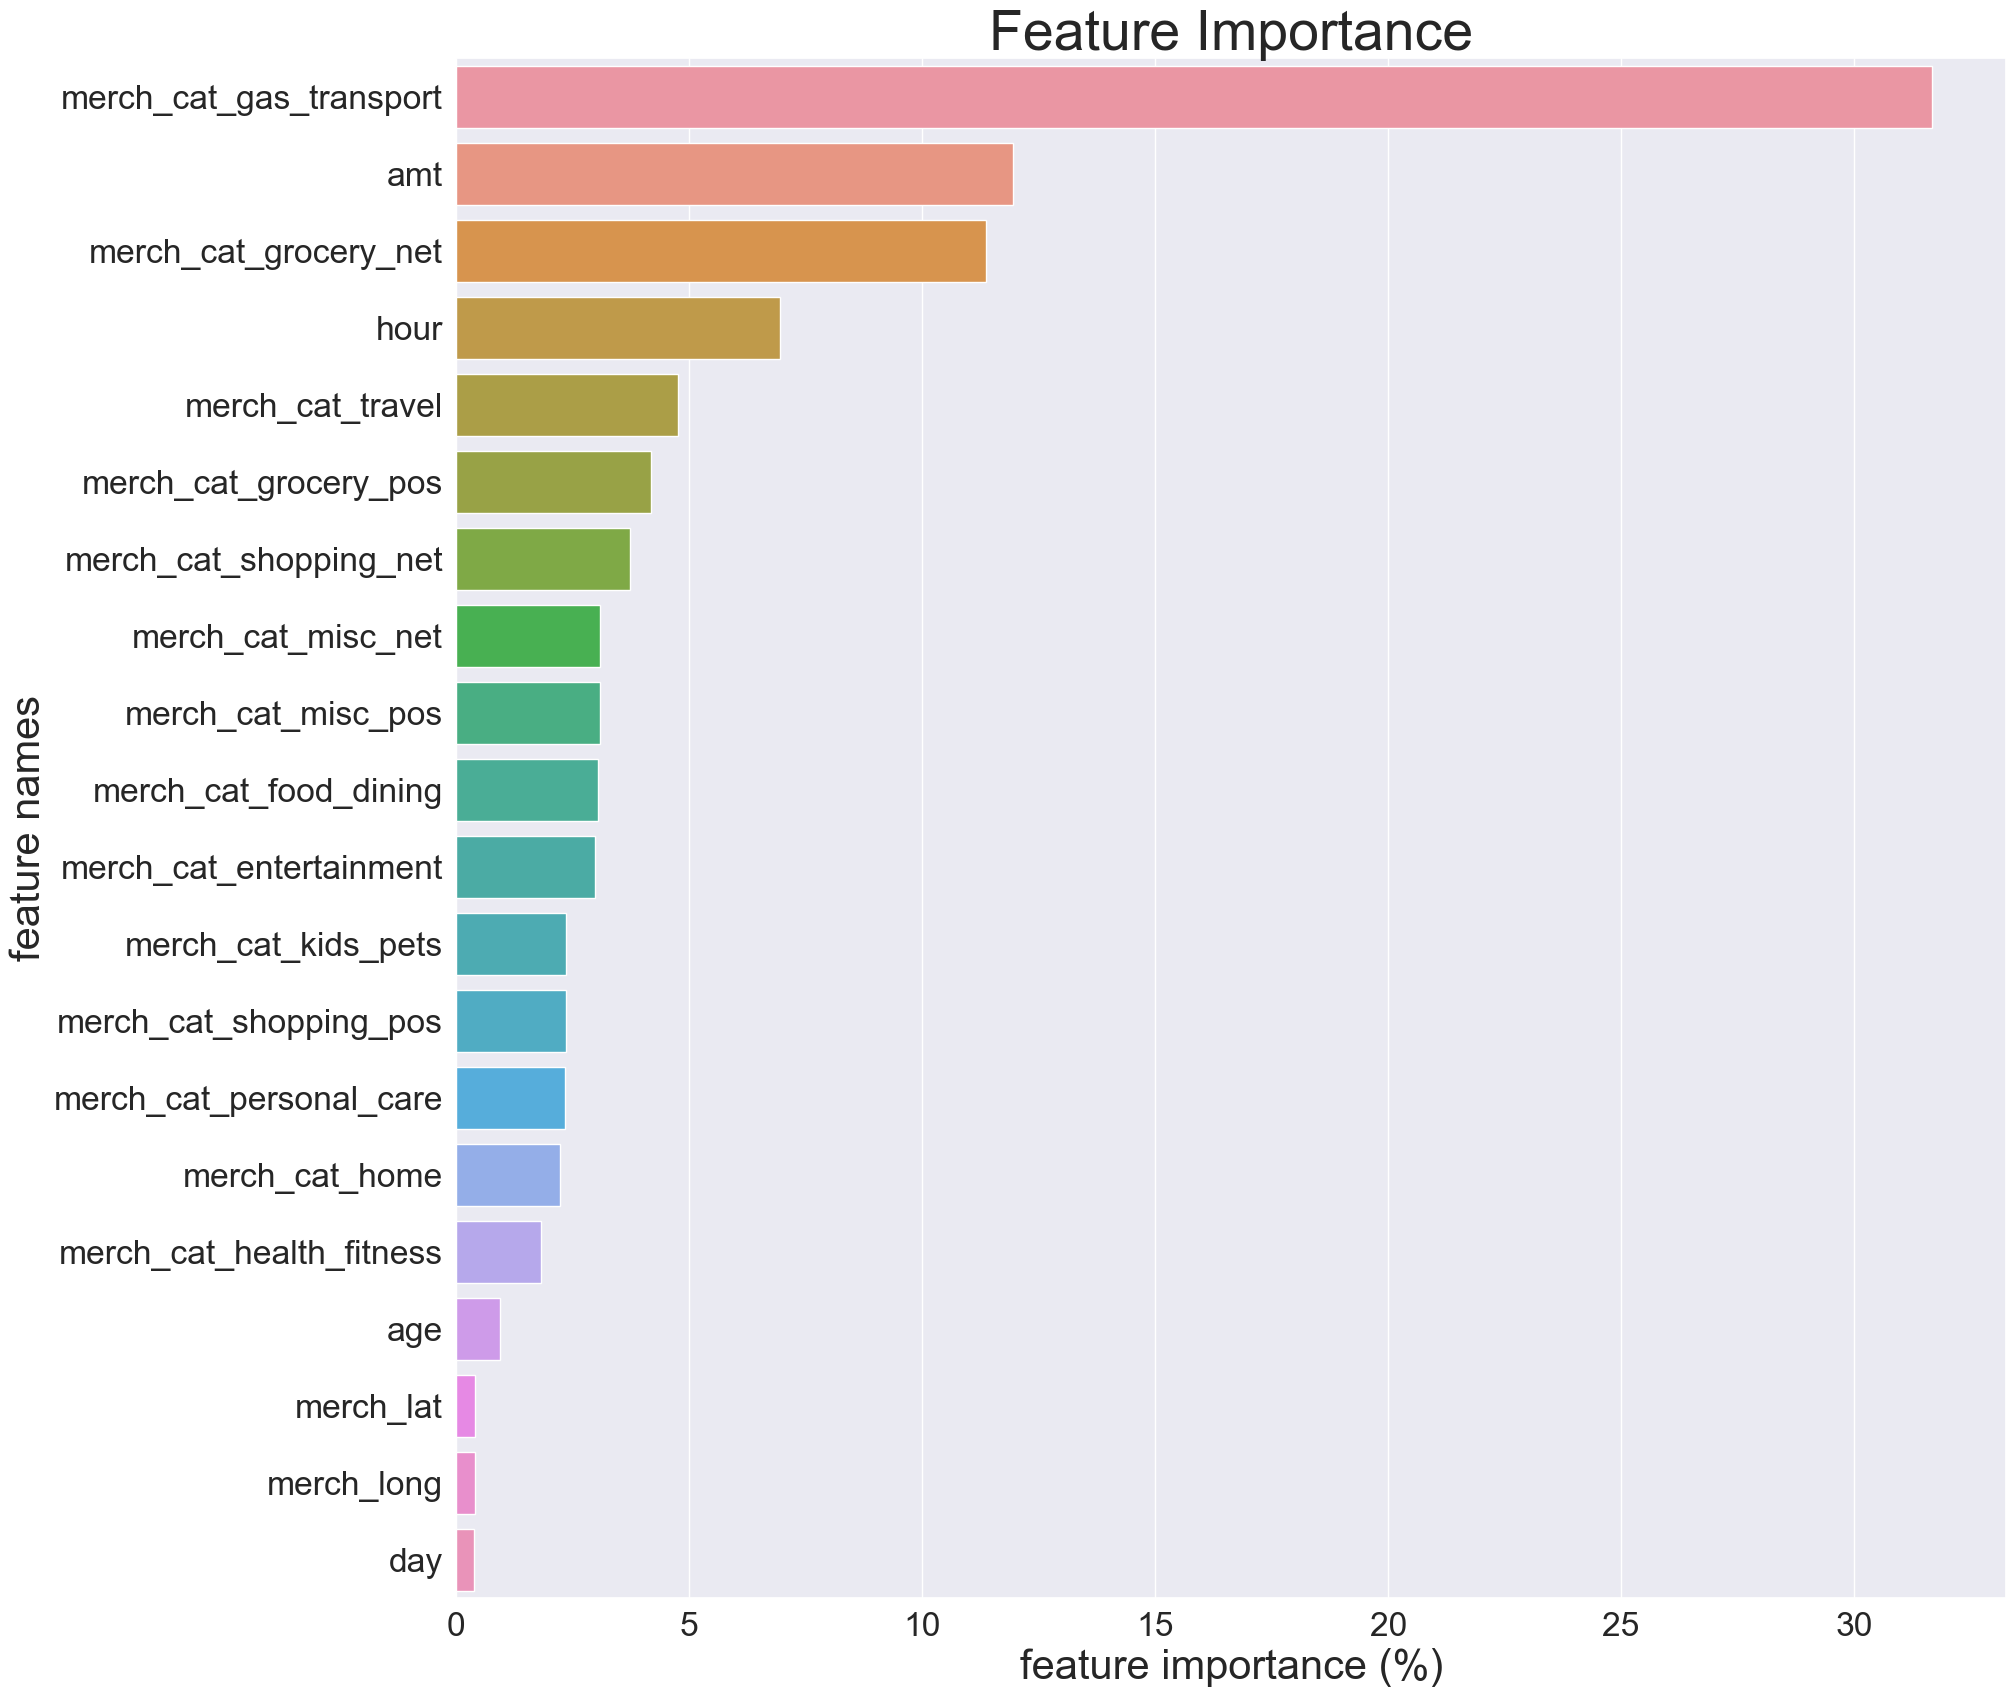

In [33]:
utils.draw_feature_importance_plot(np.array(X_train_under.columns), np.array(xgb__opt_model_under.feature_importances_))